New collect and redistribyte dynamics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import random as random
import csv
import heapq
from tqdm import tqdm
from math import factorial
import time

%matplotlib osx
font = {'family' : 'SimSun',
        'weight' : 'bold',
         'size'   : '8'}
plt.rc('font', **font)               # 步骤一（设置字体的更多属性）
plt.rc('axes', unicode_minus=False)  # 步骤二（解决坐标轴负数的负号显示问题）

In [5]:
# Hyper parameters
EPISODES = 1 # times every setting is replicated
# random.seed(1)
WriteFile = False
#WriteFile = True
FileAdd = '/Users/valarian/SJTU/SJTU/毕业论文/performanceA2M6HigherMu.csv'
WARMTIME = 0
RUNTIME = 200

In [205]:
Instance = 3
np.random.seed(Instance)
random.seed(0)

#A = 10
#M = 100
A, M = 2, 6
FileAdd = 'C:\\Rebalancing\\2020-8-31\\result\\A'+str(A)+'M'+str(M)

def getPij(a):
    temp = np.log1p(np.random.rand(A,A))
    return (temp/sum(temp)).T
Pij = getPij(A)
ArrLst = 2*np.random.rand(A)
Beta = 0.3

Tau = 1.0
C = 3
Mu = 1
N = 1
V = 1

RhoMtx = [[1/(abs(j-i)+1) for i in range(A)] for j in range(A)]
#RhoMtx = [[1 if i==j else 0.5 for i in range(A)] for j in range(A)]

In [45]:
Pij

array([[0.12764388, 0.00856408, 0.07261493, 0.19813294, 0.09923589,
        0.05434842, 0.09234608, 0.1529047 , 0.03537288, 0.15883621],
       [0.12263552, 0.08618347, 0.1206139 , 0.11778889, 0.08807912,
        0.04202374, 0.11720623, 0.11476871, 0.10086609, 0.08983433],
       [0.06324626, 0.12390904, 0.09039687, 0.15935067, 0.05905322,
        0.10273688, 0.07246368, 0.1348955 , 0.04263143, 0.15131645],
       [0.10792125, 0.06425141, 0.03810875, 0.16028651, 0.06695911,
        0.02187221, 0.1184336 , 0.10166041, 0.17493732, 0.14556943],
       [0.14313928, 0.11586944, 0.09752874, 0.07191988, 0.0845309 ,
        0.08848127, 0.0632599 , 0.10495776, 0.11658513, 0.1137277 ],
       [0.15185902, 0.11018045, 0.13688179, 0.02093358, 0.14734112,
        0.07335061, 0.08738222, 0.0153834 , 0.10262615, 0.15406165],
       [0.03861027, 0.00773452, 0.08722075, 0.16411057, 0.1505775 ,
        0.17465198, 0.01948747, 0.02286212, 0.17455526, 0.16018957],
       [0.06219609, 0.14660796, 0.0661969

In [41]:
ArrLst

array([1.30461079, 2.06236106, 2.09517017, 4.51210928, 4.89808131,
       3.1178442 , 0.41592061, 3.66499359, 3.39342701, 4.13011434])

In [98]:
RhoMtx

[[1.0, 0.5, 0.3333333333333333, 0.25],
 [0.5, 1.0, 0.5, 0.3333333333333333],
 [0.3333333333333333, 0.5, 1.0, 0.5],
 [0.25, 0.3333333333333333, 0.5, 1.0]]

# optimize code performance

In [200]:
# avoid call
from random import expovariate, random, choices
from numpy import array, argsort
from heapq import heapify, heappush, heappop
from numba import jit

class Model():
    '''
    This is the central model
    '''
    # initiate the parameters in this function
    def __init__(self, A, M, Pij, ArrLst, RhoMtx, Beta, Tau, C, Mu, N, V):     
        self.timeLimit = 2000
        #self.timeLimit = 10000
        self.areas = list(range(A))
        #self.epi = 0
        
        #self.Performance = [0] * EPISODES
        self.A, self.M, self.Pij, self.ArrLst, self.RhoMtx, self.Beta, self.Tau, self.C, self.Mu, self.N, self.V = \
            A, M, Pij, ArrLst, RhoMtx, Beta, Tau, C, Mu, N, V
        
        self.color = ['r']
        
        def get_target_number():
            A, M, ArrLst = self.A, self.M, self.ArrLst
            arr = array(ArrLst)/sum(ArrLst)
            num_dis = [int(M*x) for x in arr]
            left = M - sum(num_dis)
            for i in argsort(ArrLst)[:left]:
                num_dis[i] += 1
            return num_dis
        self.num_dis = get_target_number()
        self.arr_rank = argsort(ArrLst)[::-1]
        #print(self.num_dis, self.ArrLst, self.arr_rank)
    def reset(self):
        self.T = 0 # time cursor
        self.formerT = 0
        
        # serve performance parameters
        self.normalBikes, self.brokenBikes, self.onBikes = M, 0, M
        # maintainance performance parameters
        self.idleRate, self.BP, self.RC, self.DP = 0, 0, 0, 0
        self.arrivals, self.lostCustomers = 0, 0
        # indicators of time stamp
        [self.nt, self.bt, self.it, self.bpt, self.rct, self.dpt, self.ot] = [0]*7
        self.enormalBikes, self.ebrokenBikes, self.eon= 0, 0, 0
        # maintainance performance parameters
        self.eidleRate, self.eBP, self.eRC, self.eDP = 0, 0, 0, 0
        self.Result = [0.0] * 8
        
        self.state1 = [int(M/A)]*A + [0]*3 # Nis, BP, FC, DP, OT, I
        self.state2 = [[0]*A for i in range(A)] # Rijs
        self.F = [] # time to be empty for fixing queue
        heapify(self.F)
        
        self.scheduler = []
        heapify(self.scheduler)
        for i in range(A):
            heappush(self.scheduler, [expovariate(ArrLst[i]), -1, i, i])
        for i, _ in enumerate(range(self.V)):
            heappush(self.scheduler, [expovariate(self.Tau), 2, i, i])
        #heapq.heappush(self.scheduler, [random.expovariate(Tau), 4, i, i])
        self.stateRecord = self.state1[:A] + self.state2[0] + self.state2[1] + self.state1[-3:]
        
        # save state for drawing
        self.hn, self.hl, self.hi, self.ho = [[],[]], [[],[]], [[],[]], [[], []]
        
        return self.state1, self.state2, self.T
        
    def setRecord(self, kind):
        if kind == 1:
            self.enormalBikes = (self.enormalBikes * self.nt + self.normalBikes * (self.T - self.nt)) / self.T
            self.normalBikes, self.nt = self.normalBikes - 1, self.T
            self.eBP = (self.eBP * self.bpt + self.BP * (self.T - self.bpt)) / self.T
            self.BP, self.bpt = self.BP + 1, self.T
            self.hn[0].append(self.T)
            self.hn[1].append(self.enormalBikes/self.M)
#             self.eon = (self.eon * self.ot + self.onBikes * (self.T - self.ot)) / self.T
#             self.onBikes, self.ot = self.onBikes - 1, self.T
#             self.ho[0].append(self.T)
#             self.ho[1].append(self.eon/self.M)
        elif kind == 2:
            assert self.T>self.rct
            if self.RC == 0: 
                self.eidleRate = (self.eidleRate * self.it + (self.T - self.it)) / self.T
                self.it = self.T
                self.hi[0].append(self.T)
                self.hi[1].append(self.eidleRate)
            self.eBP = (self.eBP * self.bpt + self.BP * (self.T - self.bpt)) / self.T
            k = min(self.C, self.state1[-3])
            self.BP, self.bpt = self.BP - k, self.T
            self.eRC = (self.eRC * self.rct + self.RC * (self.T - self.rct)) / self.T
            self.RC, self.rct = self.RC + k, self.T
            
        elif kind == 3:
            assert self.T>self.rct
            self.eRC = (self.eRC * self.rct + self.RC * (self.T - self.rct)) / self.T
            self.RC, self.rct = self.RC - 1, self.T
            self.eDP = (self.eDP * self.dpt + self.DP * (self.T - self.dpt)) / self.T
            self.DP, self.dpt = self.DP + 1, self.T
            if self.RC == 0: 
                #print('ever here')
                self.eidleRate = (self.eidleRate * self.it) / self.T
                self.it = self.T
                self.hi[0].append(self.T)
                self.hi[1].append(self.eidleRate)
        elif kind == 4: 
            self.enormalBikes = (self.enormalBikes * self.nt + self.normalBikes * (self.T - self.nt)) / self.T
            k = min(self.C, self.state1[-1])
            self.normalBikes, self.nt = self.normalBikes + k, self.T
            self.eDP = (self.eDP * self.dpt + self.DP * (self.T - self.dpt)) / self.T
            self.DP, self.dpt = self.DP - k, self.T
            self.hn[0].append(self.T)
            self.hn[1].append(self.enormalBikes/self.M)
#             self.eon = (self.eon * self.ot + self.onBikes * (self.T - self.ot)) / self.T
#             self.onBikes, self.ot = self.onBikes + self.state1[-2], self.T
#             self.ho[0].append(self.T)
#             self.ho[1].append(self.eon/self.M)
        elif kind == -10:
            self.arrivals += 1
            self.hl[0].append(self.T)
            self.hl[1].append(self.lostCustomers/self.arrivals)
        elif kind == -11:
            self.lostCustomers += 1
            self.hl[0].append(self.T)
            self.hl[1].append(self.lostCustomers/self.arrivals)
        else: print('fucking wrong')
    def simulate(self):
        s = time.time()
        self.reset()
        #plt.ion()
        #plt.figure()
        print(self.V, self.N)
        while self.T <= self.timeLimit:
            while self.T <= self.timeLimit:
                self.stepForward()
            #plt.clf()
#             plt.figure()
#             plt.plot(self.hn[0], self.hn[1], )
#             plt.plot(self.hi[0], self.hi[1], )
#             plt.plot(self.hl[0], self.hl[1], )
#             plt.plot(self.ho[0], self.ho[1], )
#             plt.legend(['好车比例', '服务台空闲比例', '顾客损失比例', '在服务车比例'])
#             plt.title('A{}M{}系统性能参数-仿真时间图'.format(self.A, self.M))
#             plt.xlabel('仿真时间')
#             plt.ylabel('比例')
#             plt.pause(1)
#             self.timeLimit += int(input('more time:'))
#             #plt.pause(0.0001)
#             #self.setRecord()
#         print([self.enormalBikes/self.M, self.lostCustomers/self.arrivals, self.eidleRate, self.eBP, self.eRC, self.eDP])
#         print(np.mean(self.hn[1][-1000:]),np.mean(self.hl[1][-1000:]),np.mean(self.hi[1][-1000:]))
#         e = time.time()
#         print('-'*30, '\n', e-s)

    def addEvent(self, kind):
        if kind == -1:
            next_time = expovariate(self.ArrLst[self.start]) + self.T
            start, end = self.start, self.start
        elif kind == 1:
            next_time = expovariate(self.RhoMtx[self.start][self.terminal]) + self.T
            start, end = self.start, self.terminal
        elif kind == 2: 
            next_time = expovariate(self.Tau)
            next_time += self.T
            start, end = 'b', 'f'
            #print('add event 2')
        elif kind == 3:
            next_time = expovariate(self.Mu) 
            if self.state1[-2] < self.N:
                next_time += self.T 
                heappush(self.F, next_time)
            else: 
                next_time += heappop(self.F)
                heappush(self.F, next_time)
            start, end = 'f', 'd'
        else: 
            next_time = expovariate(self.Tau)
            next_time += self.T
            start, end = 'd', 'ni'
        heappush(self.scheduler, [next_time, kind, start, end])
    
    def assertion(self):
        su = 0
        S = list(self.state1)
        S.extend(list(np.array(self.state2).reshape(-1)))
        for s in S:
            assert(s>=0 and s<=self.M)
            su += s
        assert su == self.M
    
    def bikeArr(self):
        self.state2[self.start][self.terminal] -= 1
        heapq.heappop(self.scheduler)
        if random()<self.Beta:
            self.state1[-3] += 1
            self.setRecord(1)
        else:
            self.state1[self.terminal] += 1
        self.assertion()
    def BPover(self):
        heappop(self.scheduler)
        self.setRecord(2)
        k = min(self.state1[-3], self.C)
        for i in range(k): 
            self.addEvent(3) 
            self.state1[-3] -= 1
            self.state1[-2] += 1
        self.addEvent(4) # # of nb is 0 has been dealt before
        self.assertion()
    def repair(self):
        heappop(self.scheduler)
        self.setRecord(3)
        if self.state1[-2] <= self.N: heappop(self.F)
        self.state1[-2] -= 1
        self.state1[-1] += 1
        self.assertion()
    def DPover(self):
        heappop(self.scheduler)
        self.setRecord(4)
        k = min(self.state1[-1], self.C)
        self.state1[-1] -= k
        dbar = k
        for i in self.arr_rank: 
            if self.state1[i]>=self.num_dis[i]: continue
            else: 
                alloc_n = min(self.num_dis[i]-self.state1[i], dbar)
                self.state1[i] += alloc_n
                dbar -= alloc_n
                if dbar == 0: break
        assert dbar == 0 
        self.addEvent(2)
        self.assertion()
    def cusArr(self):
        #print(self.state1, self.state2)
        #print('------------------------')
        self.setRecord(-10)
        if self.state1[self.start] == 0:  # 但没车
            heappop(self.scheduler)
            self.addEvent(-1)
            self.setRecord(-11)
        else:
            heappop(self.scheduler)
            self.addEvent(-1)
            # below use self.terminal to represent the target
            self.terminal = choices(self.areas, weights=Pij[self.start], k=1)[0]
            self.state1[self.start] -= 1
            self.state2[self.start][self.terminal] += 1 
            self.addEvent(1)
        self.assertion()

    def stepForward(self):
        event = self.scheduler[0]
        #print(event)
        self.T, self.kind, self.start, self.terminal = event[0], event[1], event[2], event[3]
        '''
        kind of events:
        -1: customer ride a bike away
         1: a bike arrives at any area
         2: Carrier arrives at DP
         3: a bike is fixed
         4: Carrier arrives at BP
        '''
        if self.kind == 1: 
            self.bikeArr() # 顾客骑行到达
        elif self.kind == 2:
            self.BPover() # 坏车达到阈值
        elif self.kind == 3:
            self.repair() # 修好一辆车
        elif self.kind == 4:
            self.DPover() # 再分配
        else:# 顾客到达
            self.cusArr() #顾客到达

        return self.state1, self.state2, self.T

In [201]:
#N,V=5,3 #: 0.8514184240712962
#N, C = 10,10 : 0.856865518943499
#N, C = 20,20:  0.85188548526887
N,V = 1,1#14，94， 14，97
#N,V = 10,10#: 94，79，91，84
env = Model(A, M, Pij, ArrLst, RhoMtx, Beta, Tau, C, Mu, N, V)
%time env.simulate()
#v1: 0.16692424471992873 0.6173586453940136 0.9857297065232087
#v2: 0.979865779884079 0.4180826669024473 0.4162855351693233
#V3: 0.9867773825399029 0.43068396761123623 0.39705537111439315

<ipython-input-200-77b0ccf284d1>:128: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "simulate" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at <ipython-input-200-77b0ccf284d1> (130)

File "<ipython-input-200-77b0ccf284d1>", line 130:
    def simulate(self):
        s = time.time()
        ^

  @jit()
<ipython-input-200-77b0ccf284d1>:128: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "simulate" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "<ipython-input-200-77b0ccf284d1>", line 134:
    def simulate(self):
        <source elided>
        #plt.figure()
        print(self.V, self.N)
        ^

  @jit()


LoweringError: Failed in object mode pipeline (step: object mode frontend)
Failed in object mode pipeline (step: object mode backend)
[1m[1m(<class 'numba.ir.Print'>, <numba.ir.Print object at 0x7fbe8753a7b8>)
[1m
File "<ipython-input-200-77b0ccf284d1>", line 134:[0m
[1m    def simulate(self):
        <source elided>
        #plt.figure()
[1m        print(self.V, self.N)
[0m        [1m^[0m[0m
[0m
[0m[1m[1] During: lowering "print($0.9, $0.11)" at <ipython-input-200-77b0ccf284d1> (134)[0m
-------------------------------------------------------------------------------
This should not have happened, a problem has occurred in Numba's internals.

Please report the error message and traceback, along with a minimal reproducer
at: https://github.com/numba/numba/issues/new

If more help is needed please feel free to speak to the Numba core developers
directly at: https://gitter.im/numba/numba

Thanks in advance for your help in improving Numba!



# fix time problem

In [2]:
# test the simulation length needed

class Model():
    '''
    This is the central model
    '''
    # initiate the parameters in this function
    def __init__(self, A, M, Pij, ArrLst, RhoMtx, Beta, Tau, C, Mu, N, V):     
        self.timeLimit = 2000
        #self.timeLimit = 10000
        self.areas = list(range(A))
        #self.epi = 0
        
        #self.Performance = [0] * EPISODES
        self.A, self.M, self.Pij, self.ArrLst, self.RhoMtx, self.Beta, self.Tau, self.C, self.Mu, self.N, self.V = \
            A, M, Pij, ArrLst, RhoMtx, Beta, Tau, C, Mu, N, V
        
        self.color = ['r']
        
        def get_target_number():
            A, M, ArrLst = self.A, self.M, self.ArrLst
            arr = np.array(ArrLst)/sum(ArrLst)
            num_dis = [int(M*x) for x in arr]
            left = M - sum(num_dis)
            for i in np.argsort(ArrLst)[:left]:
                num_dis[i] += 1
            return num_dis
        self.num_dis = get_target_number()
        self.arr_rank = np.argsort(ArrLst)[::-1]
        #print(self.num_dis, self.ArrLst, self.arr_rank)
    def reset(self):
        self.T = 0 # time cursor
        self.formerT = 0
        
        # serve performance parameters
        self.normalBikes, self.brokenBikes, self.onBikes = M, 0, M
        # maintainance performance parameters
        self.idleRate, self.BP, self.RC, self.DP = 0, 0, 0, 0
        self.arrivals, self.lostCustomers = 0, 0
        # indicators of time stamp
        [self.nt, self.bt, self.it, self.bpt, self.rct, self.dpt, self.ot] = [0]*7
        self.enormalBikes, self.ebrokenBikes, self.eon= 0, 0, 0
        # maintainance performance parameters
        self.eidleRate, self.eBP, self.eRC, self.eDP = 0, 0, 0, 0
        self.Result = [0.0] * 8
        
        self.state1 = [int(M/A)]*A + [0]*3 # Nis, BP, FC, DP, OT, I
        self.state2 = [[0]*A for i in range(A)] # Rijs
        self.F = [] # time to be empty for fixing queue
        heapq.heapify(self.F)
        
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(A):
            heapq.heappush(self.scheduler, [random.expovariate(ArrLst[i]), -1, i, i])
        for i, _ in enumerate(range(self.V)):
            heapq.heappush(self.scheduler, [random.expovariate(self.Tau), 2, i, i])
        #heapq.heappush(self.scheduler, [random.expovariate(Tau), 4, i, i])
        self.stateRecord = self.state1[:A] + self.state2[0] + self.state2[1] + self.state1[-3:]
        
        # save state for drawing
        self.hn, self.hl, self.hi, self.ho = [[],[]], [[],[]], [[],[]], [[], []]
        
        return self.state1, self.state2, self.T
        
    def setRecord(self, kind):
        if kind == 1:
            self.enormalBikes = (self.enormalBikes * self.nt + self.normalBikes * (self.T - self.nt)) / self.T
            self.normalBikes, self.nt = self.normalBikes - 1, self.T
            self.eBP = (self.eBP * self.bpt + self.BP * (self.T - self.bpt)) / self.T
            self.BP, self.bpt = self.BP + 1, self.T
            self.hn[0].append(self.T)
            self.hn[1].append(self.enormalBikes/self.M)
#             self.eon = (self.eon * self.ot + self.onBikes * (self.T - self.ot)) / self.T
#             self.onBikes, self.ot = self.onBikes - 1, self.T
#             self.ho[0].append(self.T)
#             self.ho[1].append(self.eon/self.M)
        elif kind == 2:
            assert self.T>self.rct
            if self.RC == 0: 
                self.eidleRate = (self.eidleRate * self.it + (self.T - self.it)) / self.T
                self.it = self.T
                self.hi[0].append(self.T)
                self.hi[1].append(self.eidleRate)
            self.eBP = (self.eBP * self.bpt + self.BP * (self.T - self.bpt)) / self.T
            k = min(self.C, self.state1[-3])
            self.BP, self.bpt = self.BP - k, self.T
            self.eRC = (self.eRC * self.rct + self.RC * (self.T - self.rct)) / self.T
            self.RC, self.rct = self.RC + k, self.T
            
        elif kind == 3:
            assert self.T>self.rct
            self.eRC = (self.eRC * self.rct + self.RC * (self.T - self.rct)) / self.T
            self.RC, self.rct = self.RC - 1, self.T
            self.eDP = (self.eDP * self.dpt + self.DP * (self.T - self.dpt)) / self.T
            self.DP, self.dpt = self.DP + 1, self.T
            if self.RC == 0: 
                #print('ever here')
                self.eidleRate = (self.eidleRate * self.it) / self.T
                self.it = self.T
                self.hi[0].append(self.T)
                self.hi[1].append(self.eidleRate)
        elif kind == 4: 
            self.enormalBikes = (self.enormalBikes * self.nt + self.normalBikes * (self.T - self.nt)) / self.T
            k = min(self.C, self.state1[-1])
            self.normalBikes, self.nt = self.normalBikes + k, self.T
            self.eDP = (self.eDP * self.dpt + self.DP * (self.T - self.dpt)) / self.T
            self.DP, self.dpt = self.DP - k, self.T
            self.hn[0].append(self.T)
            self.hn[1].append(self.enormalBikes/self.M)
#             self.eon = (self.eon * self.ot + self.onBikes * (self.T - self.ot)) / self.T
#             self.onBikes, self.ot = self.onBikes + self.state1[-2], self.T
#             self.ho[0].append(self.T)
#             self.ho[1].append(self.eon/self.M)
        elif kind == -10:
            self.arrivals += 1
            self.hl[0].append(self.T)
            self.hl[1].append(self.lostCustomers/self.arrivals)
        elif kind == -11:
            self.lostCustomers += 1
            self.hl[0].append(self.T)
            self.hl[1].append(self.lostCustomers/self.arrivals)
        else: print('fucking wrong')
    
    def simulate(self):
        if WriteFile:
            with open(FileAdd, 'w') as fout:
                writer = csv.writer(fout)
                for i in range(EPISODES):
                    self.reset()
                    self.epi = i
                    while self.T <= self.timeLimit:
                        # print(self.T)
                        self.stepForward()
                writer.writerow([self.normalBikes, self.brokenBikes, self.lostCustomers/self.arrivals, self.idleRate, self.BP, self.RC, self.DP])  
        else:
            EPISODES = 1
            s = time.time()
            for i in range(EPISODES):
                self.epi = i
                self.reset()
                #plt.ion()
                #plt.figure()
                print(self.V, self.N)
                while self.T <= self.timeLimit:
                    while self.T <= self.timeLimit:
                        self.stepForward()
#                         for i in range(self.A):
#                             plt.plot(self.T, self.state1[i] )
#                             plt.legend(list(range(self.A)))
#                         plt.pause(0.000000000001)
                    #plt.clf()
                    plt.figure()
                    plt.plot(self.hn[0], self.hn[1], )
                    plt.plot(self.hi[0], self.hi[1], )
                    plt.plot(self.hl[0], self.hl[1], )
                    plt.plot(self.ho[0], self.ho[1], )
                    plt.legend(['好车比例', '服务台空闲比例', '顾客损失比例', '在服务车比例'])
                    plt.title('A{}M{}系统性能参数-仿真时间图'.format(self.A, self.M))
                    plt.xlabel('仿真时间')
                    plt.ylabel('比例')
                    plt.pause(1)
                    self.timeLimit += int(input('more time:'))
                    #plt.pause(0.0001)
                    #self.setRecord()
                print([self.enormalBikes/self.M, self.lostCustomers/self.arrivals, self.eidleRate, self.eBP, self.eRC, self.eDP])
                print(np.mean(self.hn[1][-1000:]),np.mean(self.hl[1][-1000:]),np.mean(self.hi[1][-1000:]))
            e = time.time()
            print('-'*30, '\n', e-s)

    def addEvent(self, kind):
        if kind == -1:
            next_time = random.expovariate(self.ArrLst[self.start]) + self.T
            start, end = self.start, self.start
        elif kind == 1:
            next_time = random.expovariate(self.RhoMtx[self.start][self.terminal]) + self.T
            start, end = self.start, self.terminal
        elif kind == 2: 
            next_time = random.expovariate(self.Tau)
            next_time += self.T
            start, end = 'b', 'f'
            #print('add event 2')
        elif kind == 3:
            next_time = random.expovariate(self.Mu) 
            if self.state1[-2] < self.N:
                next_time += self.T 
                heapq.heappush(self.F, next_time)
            else: 
                next_time += heapq.heappop(self.F)
                heapq.heappush(self.F, next_time)
            start, end = 'f', 'd'
        else: 
            next_time = random.expovariate(self.Tau)
            next_time += self.T
            start, end = 'd', 'ni'
        heapq.heappush(self.scheduler, [next_time, kind, start, end])
    
    def assertion(self):
        su = 0
        S = list(self.state1)
        S.extend(list(np.array(self.state2).reshape(-1)))
        for s in S:
            assert(s>=0 and s<=self.M)
            su += s
        assert su == self.M
    
    def bikeArr(self):
        self.state2[self.start][self.terminal] -= 1
        heapq.heappop(self.scheduler)
        if random.random()<self.Beta:
            self.state1[-3] += 1
            self.setRecord(1)
        else:
            self.state1[self.terminal] += 1
        self.assertion()
    def BPover(self):
        heapq.heappop(self.scheduler)
        self.setRecord(2)
        k = min(self.state1[-3], self.C)
        for i in range(k): 
            self.addEvent(3) 
            self.state1[-3] -= 1
            self.state1[-2] += 1
        self.addEvent(4) # # of nb is 0 has been dealt before
        self.assertion()
    def repair(self):
        heapq.heappop(self.scheduler)
        self.setRecord(3)
        if self.state1[-2] <= self.N: heapq.heappop(self.F)
        self.state1[-2] -= 1
        self.state1[-1] += 1
        self.assertion()
    def DPover(self):
        heapq.heappop(self.scheduler)
        self.setRecord(4)
        k = min(self.state1[-1], self.C)
        self.state1[-1] -= k
        dbar = k
        for i in self.arr_rank: 
            if self.state1[i]>=self.num_dis[i]: continue
            else: 
                alloc_n = min(self.num_dis[i]-self.state1[i], dbar)
                self.state1[i] += alloc_n
                dbar -= alloc_n
                if dbar == 0: break
        assert dbar == 0 
        self.addEvent(2)
        self.assertion()
    def cusArr(self):
        #print(self.state1, self.state2)
        #print('------------------------')
        self.setRecord(-10)
        if self.state1[self.start] == 0:  # 但没车
            heapq.heappop(self.scheduler)
            self.addEvent(-1)
            self.setRecord(-11)
        else:
            heapq.heappop(self.scheduler)
            self.addEvent(-1)
            # below use self.terminal to represent the target
            self.terminal = random.choices(self.areas, weights=Pij[self.start], k=1)[0]
            self.state1[self.start] -= 1
            self.state2[self.start][self.terminal] += 1 
            self.addEvent(1)
        self.assertion()

    def stepForward(self):
        event = self.scheduler[0]
        #print(event)
        self.T, self.kind, self.start, self.terminal = event[0], event[1], event[2], event[3]
        '''
        kind of events:
        -1: customer ride a bike away
         1: a bike arrives at any area
         2: Carrier arrives at DP
         3: a bike is fixed
         4: Carrier arrives at BP
        '''
        if self.kind == 1: 
            self.bikeArr() # 顾客骑行到达
        elif self.kind == 2:
            self.BPover() # 坏车达到阈值
        elif self.kind == 3:
            self.repair() # 修好一辆车
        elif self.kind == 4:
            self.DPover() # 再分配
        else:# 顾客到达
            self.cusArr() #顾客到达

        return self.state1, self.state2, self.T

1 1


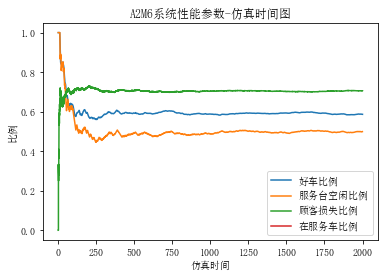

more time:10000


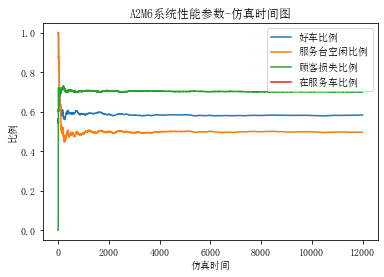

more time:0
[0.5828817725209117, 0.6993815500853034, 0.49614694168054263, 0.7776925868045445, 0.9871575042625504, 0.7378627809424448]
0.5819473972901171 0.69918721079736 0.49645042807493234
------------------------------ 
 22.109315156936646
CPU times: user 2.11 s, sys: 70.5 ms, total: 2.18 s
Wall time: 22.1 s


In [6]:
Instance = 4
np.random.seed(Instance)
random.seed(0)

#A = 10
#M = 50
A, M = 2, 6
FileAdd = 'C:\\Rebalancing\\2020-8-31\\result\\A'+str(A)+'M'+str(M)

def getPij(a):
    temp = np.log1p(np.random.rand(A,A))
    return (temp/sum(temp)).T
Pij = getPij(A)
ArrLst = 6*np.random.rand(A)
Beta = 0.3

Tau = 1.0
C = 3
Mu = 1
N = 1
V = 1

RhoMtx = [[1/(abs(j-i)+1) for i in range(A)] for j in range(A)]
env = Model(A, M, Pij, ArrLst, RhoMtx, Beta, Tau, C, Mu, N, V)
%time env.simulate()
#v1: 0.16692424471992873 0.6173586453940136 0.9857297065232087
#v2: 0.979865779884079 0.4180826669024473 0.4162855351693233
#V3: 0.9867773825399029 0.43068396761123623 0.39705537111439315

In [ ]:
# 回收、投放队列合并，有限运载能力，多个运载车，分别单独成队列

In [33]:
# test the simulation length needed

class Model():
    '''
    This is the central model
    '''
    # initiate the parameters in this function
    def __init__(self, A, M, Pij, ArrLst, RhoMtx, Beta, Tau, C, Mu, N):     
        self.timeLimit = 30000
        self.areas = list(range(A))
        #self.epi = 0
        
        #self.Performance = [0] * EPISODES
        self.A, self.M, self.Pij, self.ArrLst, self.RhoMtx, self.Beta, self.Tau, self.C, self.Mu, self.N = \
            A, M, Pij, ArrLst, RhoMtx, Beta, Tau, C, Mu, N
        
        self.color = ['r']
        
        def get_target_number():
            A, M, ArrLst = self.A, self.M, self.ArrLst
            arr = np.array(ArrLst)/sum(ArrLst)
            num_dis = [int(M*x) for x in arr]
            left = M - sum(num_dis)
            for i in np.argsort(ArrLst)[:left]:
                num_dis[i] += 1
            return num_dis
        self.num_dis = get_target_number()
        self.arr_rank = np.argsort(ArrLst)[::-1]
        #print(self.num_dis, self.ArrLst, self.arr_rank)
    def reset(self):
        self.T = 0 # time cursor
        self.formerT = 0
        
        # serve performance parameters
        self.normalBikes, self.brokenBikes, self.onBikes = M, 0, M
        # maintainance performance parameters
        self.idleRate, self.BP, self.RC, self.DP = 0, 0, 0, 0
        self.arrivals, self.lostCustomers = 0, 0
        # indicators of time stamp
        [self.nt, self.bt, self.it, self.bpt, self.rct, self.dpt, self.ot] = [0]*7
        self.enormalBikes, self.ebrokenBikes, self.eon= 0, 0, 0
        # maintainance performance parameters
        self.eidleRate, self.eBP, self.eRC, self.eDP = 0, 0, 0, 0
        self.Result = [0.0] * 8
        
        self.state1 = [int(M/A)]*A + [0]*3 # Nis, BP, FC, DP, OT, I
        self.state2 = [[0]*A for i in range(A)] # Rijs
        self.F = [] # time to be empty for fixing queue
        heapq.heapify(self.F)
        
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(A):
            heapq.heappush(self.scheduler, [random.expovariate(ArrLst[i]), -1, i, i])
        heapq.heappush(self.scheduler, [random.expovariate(Tau), 2, i, i])
        #heapq.heappush(self.scheduler, [random.expovariate(Tau), 4, i, i])
        self.stateRecord = self.state1[:A] + self.state2[0] + self.state2[1] + self.state1[-3:]
        
        # save state for drawing
        self.hn, self.hl, self.hi, self.ho = [[],[]], [[],[]], [[],[]], [[], []]
        
        return self.state1, self.state2, self.T
        
    def setRecord(self, kind):
        if kind == 1:
            self.enormalBikes = (self.enormalBikes * self.nt + self.normalBikes * (self.T - self.nt)) / self.T
            self.normalBikes, self.nt = self.normalBikes - 1, self.T
            #self.eBP = (self.eBP * self.bpt + self.BP * (self.T - self.bpt)) / self.T
            #self.BP, self.bpt = self.BP + 1, self.T
            self.hn[0].append(self.T)
            self.hn[1].append(self.enormalBikes/self.M)
#             self.eon = (self.eon * self.ot + self.onBikes * (self.T - self.ot)) / self.T
#             self.onBikes, self.ot = self.onBikes - 1, self.T
#             self.ho[0].append(self.T)
#             self.ho[1].append(self.eon/self.M)
        elif kind == 2:
            if self.RC == 0: 
                self.eidleRate = (self.eidleRate * self.it + (self.T - self.it)) / self.T
                self.hi[0].append(self.T)
                self.hi[1].append(self.eidleRate)
                self.it = self.T
            #self.eBP = (self.eBP * self.bpt + self.BP * (self.T - self.bpt)) / self.T
            #self.BP, self.bpt = self.BP - min(self.C, self.state1[-3]), self.T
            self.eRC = (self.eRC * self.rct + self.RC * (self.T - self.rct)) / self.T
            self.RC, self.rct = self.RC + min(self.C, self.state1[-3]), self.T
        elif kind == 3:
            self.eRC = (self.eRC * self.rct + self.RC * (self.T - self.rct)) / self.T
            self.RC, self.rct = self.RC - 1, self.T
            #self.eDP = (self.eDP * self.dpt + self.DP * (self.T - self.dpt)) / self.T
            #self.DP, self.dpt = self.DP + 1, self.T
            if self.RC == 0: 
                #print('ever here')
                self.eidleRate = (self.eidleRate * self.it) / self.T
                self.hi[0].append(self.T)
                self.hi[1].append(self.eidleRate)
                self.it = self.T
        elif kind == 4: 
            self.enormalBikes = (self.enormalBikes * self.nt + self.normalBikes * (self.T - self.nt)) / self.T
            self.normalBikes, self.nt = self.normalBikes + min(self.C, self.state1[-1]), self.T
            #self.eDP = (self.eDP * self.dpt + self.DP * (self.T - self.dpt)) / self.T
            #self.DP, self.dpt = self.DP - min(self.D_, self.state1[-1]), self.T
            self.hn[0].append(self.T)
            self.hn[1].append(self.enormalBikes/self.M)
#             self.eon = (self.eon * self.ot + self.onBikes * (self.T - self.ot)) / self.T
#             self.onBikes, self.ot = self.onBikes + self.state1[-2], self.T
#             self.ho[0].append(self.T)
#             self.ho[1].append(self.eon/self.M)
        elif kind == -10:
            self.arrivals += 1
            self.hl[0].append(self.T)
            self.hl[1].append(self.lostCustomers/self.arrivals)
        elif kind == -11:
            self.lostCustomers += 1
            self.hl[0].append(self.T)
            self.hl[1].append(self.lostCustomers/self.arrivals)
        else: print('fucking wrong')
    
    def simulate(self):
        if WriteFile:
            with open(FileAdd, 'w') as fout:
                writer = csv.writer(fout)
                for i in range(EPISODES):
                    self.reset()
                    self.epi = i
                    while self.T <= self.timeLimit:
                        # print(self.T)
                        self.stepForward()
                writer.writerow([self.normalBikes, self.brokenBikes, self.lostCustomers/self.arrivals, self.idleRate, self.BP, self.RC, self.DP])  
        else:
            EPISODES = 1
            s = time.time()
            for i in range(EPISODES):
                self.epi = i
                self.reset()
                #plt.ion()
                #plt.figure()
                #print(self.V, self.N)
                while self.T <= self.timeLimit:
                    while self.T <= self.timeLimit:
                        self.stepForward()
#                         for i in range(self.A):
#                             plt.plot(self.T, self.state1[i] )
#                             plt.legend(list(range(self.A)))
#                         plt.pause(0.000000000001)
                    #plt.clf()
#                     plt.figure()
#                     plt.plot(self.hn[0], self.hn[1], )
#                     plt.plot(self.hi[0], self.hi[1], )
#                     plt.plot(self.hl[0], self.hl[1], )
#                     plt.plot(self.ho[0], self.ho[1], )
#                     plt.legend(['好车比例', '服务台空闲比例', '顾客损失比例', '在服务车比例'])
#                     plt.title('A{}M{}系统性能参数-仿真时间图'.format(self.A, self.M))
#                     plt.xlabel('仿真时间')
#                     plt.ylabel('比例')
#                     plt.pause(1)
#                     self.timeLimit += int(input('more time:'))
                    #plt.pause(0.0001)
                    #self.setRecord()
                plt.figure()
                plt.plot(self.hn[0], self.hn[1], linestyle='--', c='black')
                plt.plot(self.hl[0], self.hl[1], linestyle='-.', c='black')
                plt.plot(self.hi[0], self.hi[1], linestyle='-', c='black')
                #plt.plot(self.ho[0], self.ho[1], )
                plt.legend(['好车比例', '顾客损失比例','服务台空闲比例',  '在服务车比例'])
                #plt.title('A{}M{}系统性能参数-仿真时间图'.format(self.A, self.M))
                plt.xlabel('仿真时间')
                plt.ylabel('比例')
                plt.savefig('/Users/valarian/SJTU/SJTU/毕业论文/SharingBikeMaintainence/中文论文/graph/A2M6simulationTime.png', dpi=150, bbox_inches='tight')
                #plt.show()
                #plt.pause(1)
                print([self.enormalBikes/self.M, self.lostCustomers/self.arrivals, self.eidleRate, self.eBP, self.eRC, self.eDP])
                print(np.mean(self.hn[1][-1000:]),np.mean(self.hl[1][-1000:]),np.mean(self.hi[1][-1000:]))
            e = time.time()
            print('-'*30, '\n', e-s)


    def addEvent(self, kind):
        if kind == -1:
            next_time = random.expovariate(self.ArrLst[self.start]) + self.T
            start, end = self.start, self.start
        elif kind == 1:
            next_time = random.expovariate(self.RhoMtx[self.start][self.terminal]) + self.T
            start, end = self.start, self.terminal
        elif kind == 2: 
            next_time = random.expovariate(self.Tau)
            next_time += self.T
            start, end = 'b', 'f'
            #print('add event 2')
        elif kind == 3:
            next_time = random.expovariate(self.Mu) 
            if self.state1[-2] < self.N:
                next_time += self.T 
                heapq.heappush(self.F, next_time)
            else: 
                next_time += heapq.heappop(self.F)
                heapq.heappush(self.F, next_time)
            start, end = 'f', 'd'
        else: 
            next_time = random.expovariate(self.Tau)
            next_time += self.T
            start, end = 'd', 'ni'
        heapq.heappush(self.scheduler, [next_time, kind, start, end])
    
    def assertion(self):
        su = 0
        S = list(self.state1)
        S.extend(list(np.array(self.state2).reshape(-1)))
        for s in S:
            assert(s>=0 and s<=self.M)
            su += s
        assert su == self.M
    
    def bikeArr(self):
        self.state2[self.start][self.terminal] -= 1
        heapq.heappop(self.scheduler)
        if random.random()<self.Beta:
            self.state1[-3] += 1
            self.setRecord(1)
        else:
            self.state1[self.terminal] += 1
        self.assertion()
    def BPover(self):
        heapq.heappop(self.scheduler)
        self.setRecord(2)
        k = min(self.state1[-3], self.C)
        for i in range(k): 
            self.addEvent(3) 
            self.state1[-3] -= 1
            self.state1[-2] += 1
        self.addEvent(4) # # of nb is 0 has been dealt before
        self.assertion()
    def repair(self):
        heapq.heappop(self.scheduler)
        self.setRecord(3)
        if self.state1[-2] <= self.N: heapq.heappop(self.F)
        self.state1[-2] -= 1
        self.state1[-1] += 1
        self.assertion()
    def DPover(self):
        heapq.heappop(self.scheduler)
        self.setRecord(4)
        k = min(self.state1[-1], self.C)
        self.state1[-1] -= k
        dbar = k
        for i in self.arr_rank: 
            if self.state1[i]>=self.num_dis[i]: continue
            else: 
                alloc_n = min(self.num_dis[i]-self.state1[i], dbar)
                self.state1[i] += alloc_n
                dbar -= alloc_n
                if dbar == 0: break
        assert dbar == 0 
        self.addEvent(2)
        self.assertion()
    def cusArr(self):
        #print(self.state1, self.state2)
        #print('------------------------')
        self.setRecord(-10)
        if self.state1[self.start] == 0:  # 但没车
            heapq.heappop(self.scheduler)
            self.addEvent(-1)
            self.setRecord(-11)
        else:
            heapq.heappop(self.scheduler)
            self.addEvent(-1)
            # below use self.terminal to represent the target
            self.terminal = random.choices(self.areas, weights=Pij[self.start], k=1)[0]
            self.state1[self.start] -= 1
            self.state2[self.start][self.terminal] += 1 
            self.addEvent(1)
        self.assertion()

    def stepForward(self):
        event = self.scheduler[0]
        #print(event)
        self.T, self.kind, self.start, self.terminal = event[0], event[1], event[2], event[3]
        '''
        kind of events:
        -1: customer ride a bike away
         1: a bike arrives at any area
         2: Carrier arrives at DP
         3: a bike is fixed
         4: Carrier arrives at BP
        '''
        if self.kind == 1: 
            self.bikeArr() # 顾客骑行到达
        elif self.kind == 2:
            self.BPover() # 坏车达到阈值
        elif self.kind == 3:
            self.repair() # 修好一辆车
        elif self.kind == 4:
            self.DPover() # 再分配
        else:# 顾客到达
            self.cusArr() #顾客到达

        return self.state1, self.state2, self.T
    

In [34]:
Instance = 4
np.random.seed(Instance)
random.seed(0)

#A = 10
#M = 50
A, M = 2, 6
FileAdd = 'C:\\Rebalancing\\2020-8-31\\result\\A'+str(A)+'M'+str(M)

def getPij(a):
    temp = np.log1p(np.random.rand(A,A))
    return (temp/sum(temp)).T
Pij = getPij(A)
ArrLst = np.log1p(np.random.rand(A))
Beta = 0.3

Tau = 1.0
C = 3
Mu = 1
N = 1

RhoMtx = [[1/(abs(j-i)+1) for i in range(A)] for j in range(A)]

[0.8996179282708558, 0.323363973110166, 0.8505033865734632, 0, 0.1884003440960638, 0]
0.8991536612363077 0.32293198363345815 0.8500182642362081
------------------------------ 
 1.5059690475463867
CPU times: user 1.41 s, sys: 25.1 ms, total: 1.44 s
Wall time: 1.51 s


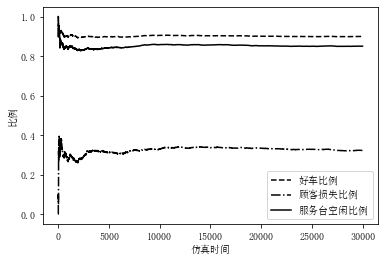

In [35]:
#N,V=5,3 #: 0.8514184240712962
#N, C = 10,10 : 0.856865518943499
#N, C = 20,20:  0.85188548526887
#N,V = 2,2#: 0.8462701724175994
env = Model(A, M, Pij, ArrLst, RhoMtx, Beta, Tau, C, Mu, N)
%time env.simulate()
#v1: 0.16692424471992873 0.6173586453940136 0.9857297065232087
#v2: 0.979865779884079 0.4180826669024473 0.4162855351693233
#V3: 0.9867773825399029 0.43068396761123623 0.39705537111439315

In [ ]:
# 回收、投放队列合并，有限运载能力，多个运载车

In [5]:
# test the simulation length needed

class Model():
    '''
    This is the central model
    '''
    # initiate the parameters in this function
    def __init__(self, A, M, Pij, ArrLst, RhoMtx, Beta, Tau, C, Mu, N):     
        self.timeLimit = 200
        self.areas = list(range(A))
        #self.epi = 0
        
        #self.Performance = [0] * EPISODES
        self.A, self.M, self.Pij, self.ArrLst, self.RhoMtx, self.Beta, self.Tau, self.C, self.Mu, self.N = \
            A, M, Pij, ArrLst, RhoMtx, Beta, Tau, C, Mu, N
        
        self.color = ['r']
        
        def get_target_number():
            A, M, ArrLst = self.A, self.M, self.ArrLst
            arr = np.array(ArrLst)/sum(ArrLst)
            num_dis = [int(M*x) for x in arr]
            left = M - sum(num_dis)
            for i in np.argsort(ArrLst)[:left]:
                num_dis[i] += 1
            return num_dis
        self.num_dis = get_target_number()
        self.arr_rank = np.argsort(ArrLst)[::-1]
        #print(self.num_dis, self.ArrLst, self.arr_rank)
    def reset(self):
        self.T = 0 # time cursor
        self.formerT = 0
        
        # serve performance parameters
        self.normalBikes, self.brokenBikes, self.onBikes = M, 0, M
        # maintainance performance parameters
        self.idleRate, self.BP, self.RC, self.DP = 0, 0, 0, 0
        self.arrivals, self.lostCustomers = 0, 0
        # indicators of time stamp
        [self.nt, self.bt, self.it, self.bpt, self.rct, self.dpt, self.ot] = [0]*7
        self.enormalBikes, self.ebrokenBikes, self.eon= 0, 0, 0
        # maintainance performance parameters
        self.eidleRate, self.eBP, self.eRC, self.eDP = 0, 0, 0, 0
        self.Result = [0.0] * 8
        
        self.state1 = [int(M/A)]*A + [0]*3 # Nis, BP, FC, DP, OT, I
        self.state2 = [[0]*A for i in range(A)] # Rijs
        self.F = [] # time to be empty for fixing queue
        heapq.heapify(self.F)
        
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(A):
            heapq.heappush(self.scheduler, [random.expovariate(ArrLst[i]), -1, i, i])
        for i, _ in enumerate(self.C):
            heapq.heappush(self.scheduler, [random.expovariate(_[1]*self.Tau), 2, _[0], _[1]])
        #heapq.heappush(self.scheduler, [random.expovariate(Tau), 4, i, i])
        self.stateRecord = self.state1[:A] + self.state2[0] + self.state2[1] + self.state1[-3:]
        
        # save state for drawing
        self.hn, self.hl, self.hi, self.ho = [[],[]], [[],[]], [[],[]], [[], []]
        
        return self.state1, self.state2, self.T
        
    def setRecord(self, kind):
        if kind == 1:
            self.enormalBikes = (self.enormalBikes * self.nt + self.normalBikes * (self.T - self.nt)) / self.T
            self.normalBikes, self.nt = self.normalBikes - 1, self.T
            #self.eBP = (self.eBP * self.bpt + self.BP * (self.T - self.bpt)) / self.T
            #self.BP, self.bpt = self.BP + 1, self.T
            self.hn[0].append(self.T)
            self.hn[1].append(self.enormalBikes/self.M)
#             self.eon = (self.eon * self.ot + self.onBikes * (self.T - self.ot)) / self.T
#             self.onBikes, self.ot = self.onBikes - 1, self.T
#             self.ho[0].append(self.T)
#             self.ho[1].append(self.eon/self.M)
        elif kind == 2:
            if self.RC == 0: 
                self.eidleRate = (self.eidleRate * self.it + (self.T - self.it)) / self.T
                self.hi[0].append(self.T)
                self.hi[1].append(self.eidleRate)
                self.it = self.T
            #self.eBP = (self.eBP * self.bpt + self.BP * (self.T - self.bpt)) / self.T
            #self.BP, self.bpt = self.BP - min(self.C, self.state1[-3]), self.T
            self.eRC = (self.eRC * self.rct + self.RC * (self.T - self.rct)) / self.T
            self.RC, self.rct = self.RC + min(self.start, self.state1[-3]), self.T
        elif kind == 3:
            self.eRC = (self.eRC * self.rct + self.RC * (self.T - self.rct)) / self.T
            self.RC, self.rct = self.RC - 1, self.T
            #self.eDP = (self.eDP * self.dpt + self.DP * (self.T - self.dpt)) / self.T
            #self.DP, self.dpt = self.DP + 1, self.T
            if self.RC == 0: 
                #print('ever here')
                self.eidleRate = (self.eidleRate * self.it) / self.T
                self.hi[0].append(self.T)
                self.hi[1].append(self.eidleRate)
                self.it = self.T
        elif kind == 4: 
            self.enormalBikes = (self.enormalBikes * self.nt + self.normalBikes * (self.T - self.nt)) / self.T
            self.normalBikes, self.nt = self.normalBikes + min(self.start, self.state1[-1]), self.T
            #self.eDP = (self.eDP * self.dpt + self.DP * (self.T - self.dpt)) / self.T
            #self.DP, self.dpt = self.DP - min(self.D_, self.state1[-1]), self.T
            self.hn[0].append(self.T)
            self.hn[1].append(self.enormalBikes/self.M)
#             self.eon = (self.eon * self.ot + self.onBikes * (self.T - self.ot)) / self.T
#             self.onBikes, self.ot = self.onBikes + self.state1[-2], self.T
#             self.ho[0].append(self.T)
#             self.ho[1].append(self.eon/self.M)
        elif kind == -10:
            self.arrivals += 1
            self.hl[0].append(self.T)
            self.hl[1].append(self.lostCustomers/self.arrivals)
        elif kind == -11:
            self.lostCustomers += 1
            self.hl[0].append(self.T)
            self.hl[1].append(self.lostCustomers/self.arrivals)
        else: print('fucking wrong')
    
    def simulate(self):
        if WriteFile:
            with open(FileAdd, 'w') as fout:
                writer = csv.writer(fout)
                for i in range(EPISODES):
                    self.reset()
                    self.epi = i
                    while self.T <= self.timeLimit:
                        # print(self.T)
                        self.stepForward()
                writer.writerow([self.normalBikes, self.brokenBikes, self.lostCustomers/self.arrivals, self.idleRate, self.BP, self.RC, self.DP])  
        else:
            EPISODES = 1
            s = time.time()
            for i in range(EPISODES):
                self.epi = i
                self.reset()
                #plt.ion()
                #plt.figure()
                while self.T <= self.timeLimit:
                    while self.T <= self.timeLimit:
                        self.stepForward()
#                         for i in range(self.A):
#                             plt.plot(self.T, self.state1[i] )
#                             plt.legend(list(range(self.A)))
#                         plt.pause(0.000000000001)
                    #plt.clf()
                    plt.figure()
                    plt.plot(self.hn[0], self.hn[1], )
                    plt.plot(self.hi[0], self.hi[1], )
                    plt.plot(self.hl[0], self.hl[1], )
                    plt.plot(self.ho[0], self.ho[1], )
                    plt.legend(['好车比例', '服务台空闲比例', '顾客损失比例', '在服务车比例'])
                    plt.title('A{}M{}系统性能参数-仿真时间图'.format(self.A, self.M))
                    plt.xlabel('仿真时间')
                    plt.ylabel('比例')
                    plt.pause(1)
                    self.timeLimit += int(input('more time:'))
                    #plt.pause(0.0001)
                    #self.setRecord()
                print([self.enormalBikes/self.M, self.lostCustomers/self.arrivals, self.eidleRate, self.eBP, self.eRC, self.eDP])
                print(np.mean(self.hn[1][-1000:]),np.mean(self.hl[1][-1000:]),np.mean(self.hi[1][-1000:]))
            e = time.time()
            print('-'*30, '\n', e-s)


    def addEvent(self, kind):
        if kind == -1:
            next_time = random.expovariate(self.ArrLst[self.start]) + self.T
            start, end = self.start, self.start
        elif kind == 1:
            next_time = random.expovariate(self.RhoMtx[self.start][self.terminal]) + self.T
            start, end = self.start, self.terminal
        elif kind == 2: 
            next_time = random.expovariate(self.terminal*self.Tau)
            next_time += self.T
            start, end = self.start, self.terminal
            #print('add event 2')
        elif kind == 3:
            next_time = random.expovariate(self.Mu) 
            if self.state1[-2] < self.N:
                next_time += self.T 
                heapq.heappush(self.F, next_time)
            else: 
                next_time += heapq.heappop(self.F)
                heapq.heappush(self.F, next_time)
            start, end = 'f', 'd'
        else: 
            next_time = random.expovariate(self.terminal*self.Tau)
            next_time += self.T
            start, end = self.start, self.terminal
        heapq.heappush(self.scheduler, [next_time, kind, start, end])
    
    def assertion(self):
        su = 0
        S = list(self.state1)
        S.extend(list(np.array(self.state2).reshape(-1)))
        for s in S:
            assert(s>=0 and s<=self.M)
            su += s
        assert su == self.M
    
    def bikeArr(self):
        self.state2[self.start][self.terminal] -= 1
        heapq.heappop(self.scheduler)
        if random.random()<self.Beta:
            self.state1[-3] += 1
            self.setRecord(1)
        else:
            self.state1[self.terminal] += 1
        self.assertion()
    def BPover(self):
        heapq.heappop(self.scheduler)
        self.setRecord(2)
        capa = self.start
        k = min(self.state1[-3], capa)
        for i in range(k): 
            self.addEvent(3) 
            self.state1[-3] -= 1
            self.state1[-2] += 1
        self.addEvent(4) # # of nb is 0 has been dealt before
        self.assertion()
    def repair(self):
        heapq.heappop(self.scheduler)
        self.setRecord(3)
        if self.state1[-2] <= self.N: heapq.heappop(self.F)
        self.state1[-2] -= 1
        self.state1[-1] += 1
        self.assertion()
    def DPover(self):
        heapq.heappop(self.scheduler)
        self.setRecord(4)
        capa = self.start
        k = min(self.state1[-1], capa)
        self.state1[-1] -= k
        dbar = k
        for i in self.arr_rank: 
            if self.state1[i]>=self.num_dis[i]: continue
            else: 
                alloc_n = min(self.num_dis[i]-self.state1[i], dbar)
                self.state1[i] += alloc_n
                dbar -= alloc_n
                if dbar == 0: break
        assert dbar == 0 
        self.addEvent(2)
        self.assertion()
    def cusArr(self):
        #print(self.state1, self.state2)
        #print('------------------------')
        self.setRecord(-10)
        if self.state1[self.start] == 0:  # 但没车
            heapq.heappop(self.scheduler)
            self.addEvent(-1)
            self.setRecord(-11)
        else:
            heapq.heappop(self.scheduler)
            self.addEvent(-1)
            # below use self.terminal to represent the target
            self.terminal = random.choices(self.areas, weights=Pij[self.start], k=1)[0]
            self.state1[self.start] -= 1
            self.state2[self.start][self.terminal] += 1 
            self.addEvent(1)
        self.assertion()

    def stepForward(self):
        event = self.scheduler[0]
        #print(event)
        self.T, self.kind, self.start, self.terminal = event[0], event[1], event[2], event[3]
        '''
        kind of events:
        -1: customer ride a bike away
         1: a bike arrives at any area
         2: Carrier arrives at DP
         3: a bike is fixed
         4: Carrier arrives at BP
        '''
        if self.kind == 1: 
            self.bikeArr() # 顾客骑行到达
        elif self.kind == 2:
            self.BPover() # 坏车达到阈值
        elif self.kind == 3:
            self.repair() # 修好一辆车
        elif self.kind == 4:
            self.DPover() # 再分配
        else:# 顾客到达
            self.cusArr() #顾客到达

        return self.state1, self.state2, self.T

In [6]:
#B_ = 5
env = Model(A, M, Pij, ArrLst, RhoMtx, Beta, Tau, C, Mu, N)
%time env.simulate()

TypeError: 'int' object is not iterable

In [ ]:
# 回收、投放队列合并，有限运载能力

In [11]:
# test the simulation length needed

class Model():
    '''
    This is the central model
    '''
    # initiate the parameters in this function
    def __init__(self, A, M, Pij, ArrLst, RhoMtx, Beta, Tau, C, Mu, N):     
        self.timeLimit = 200
        self.areas = list(range(A))
        #self.epi = 0
        
        #self.Performance = [0] * EPISODES
        self.A, self.M, self.Pij, self.ArrLst, self.RhoMtx, self.Beta, self.Tau, self.C, self.Mu, self.N = \
            A, M, Pij, ArrLst, RhoMtx, Beta, Tau, C, Mu, N
        
        self.color = ['r']
        
        def get_target_number():
            A, M, ArrLst = self.A, self.M, self.ArrLst
            arr = np.array(ArrLst)/sum(ArrLst)
            num_dis = [int(M*x) for x in arr]
            left = M - sum(num_dis)
            for i in np.argsort(ArrLst)[:left]:
                num_dis[i] += 1
            return num_dis
        self.num_dis = get_target_number()
        self.arr_rank = np.argsort(ArrLst)[::-1]
        #print(self.num_dis, self.ArrLst, self.arr_rank)
    def reset(self):
        self.T = 0 # time cursor
        self.formerT = 0
        
        # serve performance parameters
        self.normalBikes, self.brokenBikes, self.onBikes = M, 0, M
        # maintainance performance parameters
        self.idleRate, self.BP, self.RC, self.DP = 0, 0, 0, 0
        self.arrivals, self.lostCustomers = 0, 0
        # indicators of time stamp
        [self.nt, self.bt, self.it, self.bpt, self.rct, self.dpt, self.ot] = [0]*7
        self.enormalBikes, self.ebrokenBikes, self.eon= 0, 0, 0
        # maintainance performance parameters
        self.eidleRate, self.eBP, self.eRC, self.eDP = 0, 0, 0, 0
        self.Result = [0.0] * 8
        
        self.state1 = [int(M/A)]*A + [0]*3 # Nis, BP, FC, DP, OT, I
        self.state2 = [[0]*A for i in range(A)] # Rijs
        self.F = [] # time to be empty for fixing queue
        heapq.heapify(self.F)
        
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(A):
            heapq.heappush(self.scheduler, [random.expovariate(ArrLst[i]), -1, i, i])
        heapq.heappush(self.scheduler, [random.expovariate(Tau), 2, i, i])
        #heapq.heappush(self.scheduler, [random.expovariate(Tau), 4, i, i])
        self.stateRecord = self.state1[:A] + self.state2[0] + self.state2[1] + self.state1[-3:]
        
        # save state for drawing
        self.hn, self.hl, self.hi, self.ho = [[],[]], [[],[]], [[],[]], [[], []]
        
        return self.state1, self.state2, self.T
        
    def setRecord(self, kind):
        if kind == 1:
            self.enormalBikes = (self.enormalBikes * self.nt + self.normalBikes * (self.T - self.nt)) / self.T
            self.normalBikes, self.nt = self.normalBikes - 1, self.T
            #self.eBP = (self.eBP * self.bpt + self.BP * (self.T - self.bpt)) / self.T
            #self.BP, self.bpt = self.BP + 1, self.T
            self.hn[0].append(self.T)
            self.hn[1].append(self.enormalBikes/self.M)
#             self.eon = (self.eon * self.ot + self.onBikes * (self.T - self.ot)) / self.T
#             self.onBikes, self.ot = self.onBikes - 1, self.T
#             self.ho[0].append(self.T)
#             self.ho[1].append(self.eon/self.M)
        elif kind == 2:
            if self.RC == 0: 
                self.eidleRate = (self.eidleRate * self.it + (self.T - self.it)) / self.T
                self.hi[0].append(self.T)
                self.hi[1].append(self.eidleRate)
                self.it = self.T
            #self.eBP = (self.eBP * self.bpt + self.BP * (self.T - self.bpt)) / self.T
            #self.BP, self.bpt = self.BP - min(self.C, self.state1[-3]), self.T
            self.eRC = (self.eRC * self.rct + self.RC * (self.T - self.rct)) / self.T
            self.RC, self.rct = self.RC + min(self.C, self.state1[-3]), self.T
        elif kind == 3:
            self.eRC = (self.eRC * self.rct + self.RC * (self.T - self.rct)) / self.T
            self.RC, self.rct = self.RC - 1, self.T
            #self.eDP = (self.eDP * self.dpt + self.DP * (self.T - self.dpt)) / self.T
            #self.DP, self.dpt = self.DP + 1, self.T
            if self.RC == 0: 
                #print('ever here')
                self.eidleRate = (self.eidleRate * self.it) / self.T
                self.hi[0].append(self.T)
                self.hi[1].append(self.eidleRate)
                self.it = self.T
        elif kind == 4: 
            self.enormalBikes = (self.enormalBikes * self.nt + self.normalBikes * (self.T - self.nt)) / self.T
            self.normalBikes, self.nt = self.normalBikes + min(self.C, self.state1[-1]), self.T
            #self.eDP = (self.eDP * self.dpt + self.DP * (self.T - self.dpt)) / self.T
            #self.DP, self.dpt = self.DP - min(self.D_, self.state1[-1]), self.T
            self.hn[0].append(self.T)
            self.hn[1].append(self.enormalBikes/self.M)
#             self.eon = (self.eon * self.ot + self.onBikes * (self.T - self.ot)) / self.T
#             self.onBikes, self.ot = self.onBikes + self.state1[-2], self.T
#             self.ho[0].append(self.T)
#             self.ho[1].append(self.eon/self.M)
        elif kind == -10:
            self.arrivals += 1
            self.hl[0].append(self.T)
            self.hl[1].append(self.lostCustomers/self.arrivals)
            self.hi[0].append(self.T)
            self.hi[1].append(self.eidleRate)
        elif kind == -11:
            self.lostCustomers += 1
            self.hl[0].append(self.T)
            self.hl[1].append(self.lostCustomers/self.arrivals)
        else: print('fucking wrong')
    
    def simulate(self):
        if WriteFile:
            with open(FileAdd, 'w') as fout:
                writer = csv.writer(fout)
                for i in range(EPISODES):
                    self.reset()
                    self.epi = i
                    while self.T <= self.timeLimit:
                        # print(self.T)
                        self.stepForward()
                writer.writerow([self.normalBikes, self.brokenBikes, self.lostCustomers/self.arrivals, self.idleRate, self.BP, self.RC, self.DP])  
        else:
            EPISODES = 1
            s = time.time()
            for i in range(EPISODES):
                self.epi = i
                self.reset()
                #plt.ion()
                #plt.figure()
                #self.timeLimit = 30000
                while self.T <= self.timeLimit:
                    while self.T <= self.timeLimit:
                        self.stepForward()
#                         for i in range(self.A):
#                             plt.plot(self.T, self.state1[i] )
#                             plt.legend(list(range(self.A)))
#                         plt.pause(0.000000000001)
                    #plt.clf()
                    plt.figure()
                    plt.plot(self.hn[0], self.hn[1], )
                    plt.plot(self.hi[0], self.hi[1], )
                    plt.plot(self.hl[0], self.hl[1], )
                    #plt.plot(self.ho[0], self.ho[1], )
                    plt.legend(['好车比例', '服务台空闲比例', '顾客损失比例'])
                    plt.title('A{}M{}系统性能参数-仿真时间图'.format(self.A, self.M))
                    plt.xlabel('仿真时间')
                    plt.ylabel('比例')
                    #plt.pause(1)
                    self.timeLimit += int(input('more time:'))
                    #plt.pause(0.0001)
                    #self.setRecord()
                    plt.savefig('/Users/valarian/SJTU/SJTU/毕业论文/SharingBikeMaintainence/中文论文/graph/sim/sim_timeA'+str(self.A)+'M'+str(M)+'.png', dpi=150)
                print([self.enormalBikes/self.M, self.lostCustomers/self.arrivals, self.eidleRate, self.eBP, self.eRC, self.eDP])
                print(np.mean(self.hn[1][-1000:]),np.mean(self.hl[1][-1000:]),np.mean(self.hi[1][-1000:]))
            e = time.time()
            print('-'*30, '\n', e-s)


    def addEvent(self, kind):
        if kind == -1:
            next_time = random.expovariate(self.ArrLst[self.start]) + self.T
            start, end = self.start, self.start
        elif kind == 1:
            next_time = random.expovariate(self.RhoMtx[self.start][self.terminal]) + self.T
            start, end = self.start, self.terminal
        elif kind == 2: 
            next_time = random.expovariate(self.Tau)
            next_time += self.T
            start, end = 'b', 'f'
            #print('add event 2')
        elif kind == 3:
            next_time = random.expovariate(self.Mu) 
            if self.state1[-2] < self.N:
                next_time += self.T 
                heapq.heappush(self.F, next_time)
            else: 
                next_time += heapq.heappop(self.F)
                heapq.heappush(self.F, next_time)
            start, end = 'f', 'd'
        else: 
            next_time = random.expovariate(self.Tau)
            next_time += self.T
            start, end = 'd', 'ni'
        heapq.heappush(self.scheduler, [next_time, kind, start, end])
    
    def assertion(self):
        su = 0
        S = list(self.state1)
        S.extend(list(np.array(self.state2).reshape(-1)))
        for s in S:
            assert(s>=0 and s<=self.M)
            su += s
        assert su == self.M
    
    def bikeArr(self):
        self.state2[self.start][self.terminal] -= 1
        heapq.heappop(self.scheduler)
        if random.random()<self.Beta:
            self.state1[-3] += 1
            self.setRecord(1)
        else:
            self.state1[self.terminal] += 1
        self.assertion()
    def BPover(self):
        heapq.heappop(self.scheduler)
        self.setRecord(2)
        k = min(self.state1[-3], self.C)
        for i in range(k): 
            self.addEvent(3) 
            self.state1[-3] -= 1
            self.state1[-2] += 1
        self.addEvent(4) # # of nb is 0 has been dealt before
        self.assertion()
    def repair(self):
        heapq.heappop(self.scheduler)
        self.setRecord(3)
        if self.state1[-2] <= self.N: heapq.heappop(self.F)
        self.state1[-2] -= 1
        self.state1[-1] += 1
        self.assertion()
    def DPover(self):
        heapq.heappop(self.scheduler)
        self.setRecord(4)
        k = min(self.state1[-1], self.C)
        self.state1[-1] -= k
        dbar = k
        for i in self.arr_rank: 
            if self.state1[i]>=self.num_dis[i]: continue
            else: 
                alloc_n = min(self.num_dis[i]-self.state1[i], dbar)
                self.state1[i] += alloc_n
                dbar -= alloc_n
                if dbar == 0: break
        assert dbar == 0 
        self.addEvent(2)
        self.assertion()
    def cusArr(self):
        #print(self.state1, self.state2)
        #print('------------------------')
        self.setRecord(-10)
        if self.state1[self.start] == 0:  # 但没车
            heapq.heappop(self.scheduler)
            self.addEvent(-1)
            self.setRecord(-11)
        else:
            heapq.heappop(self.scheduler)
            self.addEvent(-1)
            # below use self.terminal to represent the target
            self.terminal = random.choices(self.areas, weights=Pij[self.start], k=1)[0]
            self.state1[self.start] -= 1
            self.state2[self.start][self.terminal] += 1 
            self.addEvent(1)
        self.assertion()

    def stepForward(self):
        event = self.scheduler[0]
        #print(event)
        self.T, self.kind, self.start, self.terminal = event[0], event[1], event[2], event[3]
        '''
        kind of events:
        -1: customer ride a bike away
         1: a bike arrives at any area
         2: Carrier arrives at DP
         3: a bike is fixed
         4: Carrier arrives at BP
        '''
        if self.kind == 1: 
            self.bikeArr() # 顾客骑行到达
        elif self.kind == 2:
            self.BPover() # 坏车达到阈值
        elif self.kind == 3:
            self.repair() # 修好一辆车
        elif self.kind == 4:
            self.DPover() # 再分配
        else:# 顾客到达
            self.cusArr() #顾客到达

        return self.state1, self.state2, self.T

In [12]:
Instance = 4
np.random.seed(Instance)
random.seed(0)

#A = 10
#M = 50
A, M = 2, 6
FileAdd = 'C:\\Rebalancing\\2020-8-31\\result\\A'+str(A)+'M'+str(M)

def getPij(a):
    temp = np.log1p(np.random.rand(A,A))
    return (temp/sum(temp)).T
Pij = getPij(A)
ArrLst = np.log1p((np.random.rand(A)))
Beta = 0.3

Tau = 1.0
C = 3
Mu = 1
N = 1

RhoMtx = [[1/(abs(j-i)+1) for i in range(A)] for j in range(A)]

[0.8996179282708558, 0.323363973110166, 0.8505033865734632, 0, 0.1884003440960638, 0]
0.8991536612363077 0.32293198363345815 0.8503018774660355
------------------------------ 
 1.20172119140625
CPU times: user 1.16 s, sys: 19 ms, total: 1.18 s
Wall time: 1.2 s


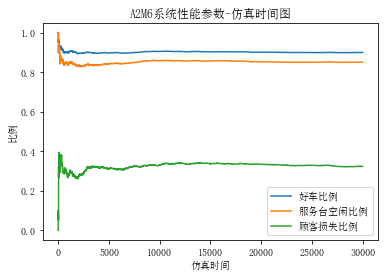

In [13]:
#B_ = 5
env = Model(A, M, Pij, ArrLst, RhoMtx, Beta, Tau, C, Mu, N)
%time env.simulate()

In [ ]:
# 回收、投放队列分开，有限运载能力

In [21]:
# test the simulation length needed

class Model():
    '''
    This is the central model
    '''
    # initiate the parameters in this function
    def __init__(self, A, M, Pij, ArrLst, RhoMtx, Beta, Tau, C, Mu, N):     
        self.timeLimit = 200
        self.areas = list(range(A))
        #self.epi = 0
        
        #self.Performance = [0] * EPISODES
        self.A, self.M, self.Pij, self.ArrLst, self.RhoMtx, self.Beta, self.Tau, self.C, self.Mu, self.N = \
            A, M, Pij, ArrLst, RhoMtx, Beta, Tau, C, Mu, N
        
        self.color = ['r']
        
        def get_target_number():
            A, M, ArrLst = self.A, self.M, self.ArrLst
            arr = np.array(ArrLst)/sum(ArrLst)
            num_dis = [int(M*x) for x in arr]
            left = M - sum(num_dis)
            for i in np.argsort(ArrLst)[:left]:
                num_dis[i] += 1
            return num_dis
        self.num_dis = get_target_number()
        self.arr_rank = np.argsort(ArrLst)[::-1]
        #print(self.num_dis, self.ArrLst, self.arr_rank)
    def reset(self):
        self.T = 0 # time cursor
        self.formerT = 0
        
        # serve performance parameters
        self.normalBikes, self.brokenBikes, self.onBikes = M, 0, M
        # maintainance performance parameters
        self.idleRate, self.BP, self.RC, self.DP = 0, 0, 0, 0
        self.arrivals, self.lostCustomers = 0, 0
        # indicators of time stamp
        [self.nt, self.bt, self.it, self.bpt, self.rct, self.dpt, self.ot] = [0]*7
        self.enormalBikes, self.ebrokenBikes, self.eon= 0, 0, 0
        # maintainance performance parameters
        self.eidleRate, self.eBP, self.eRC, self.eDP = 0, 0, 0, 0
        self.Result = [0.0] * 8
        
        self.state1 = [int(M/A)]*A + [0]*3 # Nis, BP, FC, DP, OT, I
        self.state2 = [[0]*A for i in range(A)] # Rijs
        self.F = [] # time to be empty for fixing queue
        heapq.heapify(self.F)
        
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(A):
            heapq.heappush(self.scheduler, [random.expovariate(ArrLst[i]), -1, i, i])
        heapq.heappush(self.scheduler, [random.expovariate(Tau), 2, i, i])
        heapq.heappush(self.scheduler, [random.expovariate(Tau), 4, i, i])
        self.stateRecord = self.state1[:A] + self.state2[0] + self.state2[1] + self.state1[-3:]
        
        # save state for drawing
        self.hn, self.hl, self.hi, self.ho = [[],[]], [[],[]], [[],[]], [[], []]
        
        return self.state1, self.state2, self.T
        
    def setRecord(self, kind):
        if kind == 1:
            self.enormalBikes = (self.enormalBikes * self.nt + self.normalBikes * (self.T - self.nt)) / self.T
            self.normalBikes, self.nt = self.normalBikes - 1, self.T
            #self.eBP = (self.eBP * self.bpt + self.BP * (self.T - self.bpt)) / self.T
            #self.BP, self.bpt = self.BP + 1, self.T
            self.hn[0].append(self.T)
            self.hn[1].append(self.enormalBikes/self.M)
#             self.eon = (self.eon * self.ot + self.onBikes * (self.T - self.ot)) / self.T
#             self.onBikes, self.ot = self.onBikes - 1, self.T
#             self.ho[0].append(self.T)
#             self.ho[1].append(self.eon/self.M)
        elif kind == 2:
            if self.RC == 0: 
                self.eidleRate = (self.eidleRate * self.it + (self.T - self.it)) / self.T
                self.hi[0].append(self.T)
                self.hi[1].append(self.eidleRate)
                self.it = self.T
            #self.eBP = (self.eBP * self.bpt + self.BP * (self.T - self.bpt)) / self.T
            #self.BP, self.bpt = self.BP - min(self.C, self.state1[-3]), self.T
            self.eRC = (self.eRC * self.rct + self.RC * (self.T - self.rct)) / self.T
            self.RC, self.rct = self.RC + min(self.C, self.state1[-3]), self.T
        elif kind == 3:
            self.eRC = (self.eRC * self.rct + self.RC * (self.T - self.rct)) / self.T
            self.RC, self.rct = self.RC - 1, self.T
            #self.eDP = (self.eDP * self.dpt + self.DP * (self.T - self.dpt)) / self.T
            #self.DP, self.dpt = self.DP + 1, self.T
            if self.RC == 0: 
                #print('ever here')
                self.eidleRate = (self.eidleRate * self.it) / self.T
                self.hi[0].append(self.T)
                self.hi[1].append(self.eidleRate)
                self.it = self.T
        elif kind == 4: 
            self.enormalBikes = (self.enormalBikes * self.nt + self.normalBikes * (self.T - self.nt)) / self.T
            self.normalBikes, self.nt = self.normalBikes + min(self.C, self.state1[-1]), self.T
            #self.eDP = (self.eDP * self.dpt + self.DP * (self.T - self.dpt)) / self.T
            #self.DP, self.dpt = self.DP - min(self.D_, self.state1[-1]), self.T
            self.hn[0].append(self.T)
            self.hn[1].append(self.enormalBikes/self.M)
#             self.eon = (self.eon * self.ot + self.onBikes * (self.T - self.ot)) / self.T
#             self.onBikes, self.ot = self.onBikes + self.state1[-2], self.T
#             self.ho[0].append(self.T)
#             self.ho[1].append(self.eon/self.M)
        elif kind == -10:
            self.arrivals += 1
            self.hl[0].append(self.T)
            self.hl[1].append(self.lostCustomers/self.arrivals)
        elif kind == -11:
            self.lostCustomers += 1
            self.hl[0].append(self.T)
            self.hl[1].append(self.lostCustomers/self.arrivals)
        else: print('fucking wrong')
    
    def simulate(self):
        
        EPISODES = 1
        s = time.time()
        for i in range(EPISODES):
            self.epi = i
            self.reset()
            #plt.ion()
            #plt.figure()
            while self.T <= self.timeLimit:
                while self.T <= self.timeLimit:
                    self.stepForward()
#                         for i in range(self.A):
#                             plt.plot(self.T, self.state1[i] )
#                             plt.legend(list(range(self.A)))
#                         plt.pause(0.000000000001)
                #plt.clf()
                plt.figure()
                plt.plot(self.hn[0], self.hn[1], )
                plt.plot(self.hi[0], self.hi[1], )
                plt.plot(self.hl[0], self.hl[1], )
                plt.plot(self.ho[0], self.ho[1], )
                plt.legend(['好车比例', '服务台空闲比例', '顾客损失比例', '在服务车比例'])
                plt.title('A{}M{}系统性能参数-仿真时间图'.format(self.A, self.M))
                plt.xlabel('仿真时间')
                plt.ylabel('比例')
                plt.pause(1)
                self.timeLimit += int(input('more time:'))
                #plt.pause(0.0001)
                #self.setRecord()
            print([self.enormalBikes/self.M, self.lostCustomers/self.arrivals, self.eidleRate, self.eBP, self.eRC, self.eDP])
            print(np.mean(self.hn[1][-1000:]),np.mean(self.hl[1][-1000:]),np.mean(self.hi[1][-1000:]))
        e = time.time()
        print('-'*30, '\n', e-s)


    def addEvent(self, kind):
        if kind == -1:
            next_time = random.expovariate(self.ArrLst[self.start]) + self.T
            start, end = self.start, self.start
        elif kind == 1:
            next_time = random.expovariate(self.RhoMtx[self.start][self.terminal]) + self.T
            start, end = self.start, self.terminal
        elif kind == 2: 
            next_time = random.expovariate(self.Tau)
            next_time += self.T
            start, end = 'b', 'f'
            #print('add event 2')
        elif kind == 3:
            next_time = random.expovariate(self.Mu) 
            if self.state1[-2] < self.N:
                next_time += self.T 
                heapq.heappush(self.F, next_time)
            else: 
                next_time += heapq.heappop(self.F)
                heapq.heappush(self.F, next_time)
            start, end = 'f', 'd'
        else: 
            next_time = random.expovariate(self.Tau)
            next_time += self.T
            start, end = 'd', 'ni'
        heapq.heappush(self.scheduler, [next_time, kind, start, end])
    
    def assertion(self):
        su = 0
        S = list(self.state1)
        S.extend(list(np.array(self.state2).reshape(-1)))
        for s in S:
            assert(s>=0 and s<=self.M)
            su += s
        assert su == self.M
    
    def bikeArr(self):
        self.state2[self.start][self.terminal] -= 1
        heapq.heappop(self.scheduler)
        if random.random()<self.Beta:
            self.state1[-3] += 1
            self.setRecord(1)
        else:
            self.state1[self.terminal] += 1
        self.assertion()
    def BPover(self):
        heapq.heappop(self.scheduler)
        self.setRecord(2)
        k = min(self.state1[-3], self.C)
        for i in range(k): 
            self.addEvent(3) 
            self.state1[-3] -= 1
            self.state1[-2] += 1
        self.addEvent(2) # # of nb is 0 has been dealt before
        self.assertion()
    def repair(self):
        heapq.heappop(self.scheduler)
        self.setRecord(3)
        if self.state1[-2] <= self.N: heapq.heappop(self.F)
        self.state1[-2] -= 1
        self.state1[-1] += 1
        self.assertion()
    def DPover(self):
        heapq.heappop(self.scheduler)
        self.setRecord(4)
        k = min(self.state1[-1], self.C)
        self.state1[-1] -= k
        dbar = k
        for i in self.arr_rank: 
            if self.state1[i]>=self.num_dis[i]: continue
            else: 
                alloc_n = min(self.num_dis[i]-self.state1[i], dbar)
                self.state1[i] += alloc_n
                dbar -= alloc_n
                if dbar == 0: break
        assert dbar == 0 
        self.addEvent(4)
        self.assertion()
    def cusArr(self):
        #print(self.state1, self.state2)
        #print('------------------------')
        self.setRecord(-10)
        if self.state1[self.start] == 0:  # 但没车
            heapq.heappop(self.scheduler)
            self.addEvent(-1)
            self.setRecord(-11)
        else:
            heapq.heappop(self.scheduler)
            self.addEvent(-1)
            # below use self.terminal to represent the target
            self.terminal = random.choices(self.areas, weights=Pij[self.start], k=1)[0]
            self.state1[self.start] -= 1
            self.state2[self.start][self.terminal] += 1 
            self.addEvent(1)
        self.assertion()

    def stepForward(self):
        event = self.scheduler[0]
        #print(event)
        self.T, self.kind, self.start, self.terminal = event[0], event[1], event[2], event[3]
        '''
        kind of events:
        -1: customer ride a bike away
         1: a bike arrives at any area
         2: Carrier arrives at DP
         3: a bike is fixed
         4: Carrier arrives at BP
        '''
        if self.kind == 1: 
            self.bikeArr() # 顾客骑行到达
        elif self.kind == 2:
            self.BPover() # 坏车达到阈值
        elif self.kind == 3:
            self.repair() # 修好一辆车
        elif self.kind == 4:
            self.DPover() # 再分配
        else:# 顾客到达
            self.cusArr() #顾客到达

        return self.state1, self.state2, self.T

In [15]:
A, M, Pij, ArrLst, RhoMtx, Beta, Tau, C, Mu, N

(10, 50, array([[0.10729086, 0.14302015, 0.16735307, 0.05756347, 0.07531951,
         0.11065357, 0.03618093, 0.16708534, 0.06771206, 0.06782104],
        [0.12852131, 0.10113203, 0.13990682, 0.13658364, 0.0863711 ,
         0.08663113, 0.02494037, 0.09155569, 0.08256653, 0.12179139],
        [0.11059437, 0.10546006, 0.08895981, 0.08810339, 0.12407602,
         0.16113779, 0.11830169, 0.15976454, 0.01457636, 0.02902597],
        [0.11034651, 0.16623353, 0.14636239, 0.11418483, 0.0148368 ,
         0.02465139, 0.03283721, 0.12000721, 0.13349462, 0.13704551],
        [0.13136721, 0.02552256, 0.04157413, 0.00692319, 0.1900012 ,
         0.07054736, 0.06674568, 0.2058355 , 0.16695159, 0.09453159],
        [0.16742809, 0.02807042, 0.16620646, 0.16160899, 0.17244193,
         0.05024964, 0.10546659, 0.01291602, 0.07908991, 0.05652195],
        [0.10616481, 0.00585474, 0.03918386, 0.13967532, 0.05584745,
         0.14702341, 0.17531465, 0.07284539, 0.12309391, 0.13499646],
        [0.2088982 

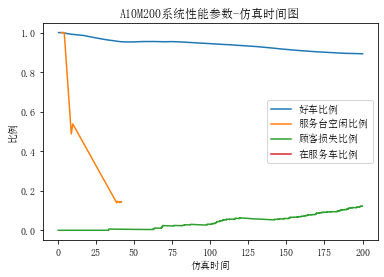

more time:20000


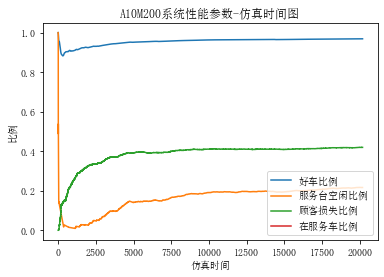

more time:0
[0.9685776538885922, 0.4193952982440562, 0.21649058527097223, 0, 4.5115937271908875, 0]
0.9684547685296416 0.4194305425453212 0.21343709750120257
------------------------------ 
 37.86988592147827
CPU times: user 13.5 s, sys: 220 ms, total: 13.7 s
Wall time: 37.9 s


In [22]:
#B_ = 5
env = Model(A, M, Pij, ArrLst, RhoMtx, Beta, Tau, C, Mu, N)
%time env.simulate()

In [27]:
A, M, D_ = 8,20,2
ArrLst = np.log1p(np.random.rand(A))
def get_target_number(A, M, D_, ArrLst):
    arr = np.array(ArrLst)/sum(ArrLst)
    num_dis = [int(M*x) for x in arr]
    left = M - sum(num_dis)
    for i in np.argsort(ArrLst)[:left]:
        num_dis[i] += 1
    return num_dis
num_dis = get_target_number(A, M, D_, ArrLst)
arr_rank = np.argsort(ArrLst)[::-1]
print(num_dis, '\n', ArrLst, '\n', arr_rank)

[3, 4, 2, 1, 3, 2, 3, 2] 
 [0.58014979 0.62395213 0.15970558 0.07227283 0.47046772 0.15526907
 0.55007336 0.34248545] 
 [1 0 6 4 7 2 5 3]


In [33]:
# cen parameters
import numpy as np
import random as random

# set parameters
# set the parameters
# get the number of states S
'''
A: number of areas
M: number of total bikes
S: number of total states
Pij: transfering possibility matrix
Beta: broken rate
ArrMtx: arrival rates of each area
Gamma: gathering rate
Mu: fix rate
Delta: distributing rate
RhoMtx: matrix of ride rates
N: number of fix servers
B_: valve value at broken pool
D_: valve value at distributing pool
'''


Instance = 4

np.random.seed(Instance)
random.seed(0)

#A = 10
#M = 50
A, M = 2, 6
FileAdd = 'C:\\Rebalancing\\nowModel\\result\\A'+str(A)+'M'+str(M)

def getPij(a):
    temp = np.log1p(np.random.rand(A,A))
    return (temp/sum(temp)).T
Pij = getPij(A)
ArrLst = np.log1p((np.random.rand(A)))
Beta = 0.3
#RhoMtx = [[1.0] * A for i in range(A)]
#RhoMtx = np.random.rand(A, A)

Tau = 1.0
C = 1
Mu = 1
N = 1


#RhoMtx = [[1.0, 0.5], 
#          [0.5, 1.0]]
RhoMtx = [[1/(abs(j-i)+1) for i in range(A)] for j in range(A)]

In [34]:
import numpy as np
import pandas as pd
import random as random
import csv
import heapq
from tqdm import tqdm
from math import factorial
from multiprocessing import Pool
import time
import os
import shutil

from testParameters import A, M, Pij, ArrLst, RhoMtx, Beta, Tau, C, Mu, N, FileAdd
#from testODE import getStateDicts


# set the parameters
# get the number of states S
'''
A: number of areas
M: number of total bikes
S: number of total states
Pij: transfering possibility matrix
Beta: broken rate
ArrMtx: arrival rates of each area
Gamma: gathering rate
Mu: fix rate
Delta: distributing rate
RhoMtx: matrix of ride rates
N: number of fix servers
B_: valve value at broken pool
D_: valve value at distributing pool
'''


# test the simulation length needed

class Model():
    '''
    This is the central model
    '''
    # initiate the parameters in this function
    def __init__(self, A, M, Pij, ArrLst, RhoMtx, Beta, Tau, C, Mu, N):     
        self.timeLimit = 25000
        self.areas = list(range(A))
        #self.epi = 0
        
        #self.Performance = [0] * EPISODES
        self.A, self.M, self.Pij, self.ArrLst, self.RhoMtx, self.Beta, self.Tau, self.C, self.Mu, self.N = \
            A, M, Pij, ArrLst, RhoMtx, Beta, Tau, C, Mu, N
        
        self.color = ['r']
        
        def get_target_number():
            A, M, ArrLst = self.A, self.M, self.ArrLst
            arr = np.array(ArrLst)/sum(ArrLst)
            num_dis = [int(M*x) for x in arr]
            left = M - sum(num_dis)
            for i in np.argsort(ArrLst)[:left]:
                num_dis[i] += 1
            return num_dis
        self.num_dis = get_target_number()
        self.arr_rank = np.argsort(ArrLst)[::-1]
        #print(self.num_dis, self.ArrLst, self.arr_rank)
    def reset(self):
        self.T = 0 # time cursor
        self.formerT = 0
        
        # serve performance parameters
        self.normalBikes, self.brokenBikes, self.onBikes = M, 0, M
        # maintainance performance parameters
        self.idleRate, self.BP, self.RC, self.DP = 0, 0, 0, 0
        self.arrivals, self.lostCustomers = 0, 0
        # indicators of time stamp
        [self.nt, self.bt, self.it, self.bpt, self.rct, self.dpt, self.ot] = [0]*7
        self.enormalBikes, self.ebrokenBikes, self.eon= 0, 0, 0
        # maintainance performance parameters
        self.eidleRate, self.eBP, self.eRC, self.eDP = 0, 0, 0, 0
        self.Result = [0.0] * 8
        
        self.state1 = [int(M/A)]*A + [0]*5 # Nis, BP, FC, DP, OT, I
        self.state2 = [[0]*A for i in range(A)] # Rijs
        self.F = [] # time to be empty for fixing queue
        heapq.heapify(self.F)
        
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(A):
            heapq.heappush(self.scheduler, [random.expovariate(ArrLst[i]), -1, i, i])
        heapq.heappush(self.scheduler, [random.expovariate(Tau), 2, i, i])
        self.stateRecord = self.state1[:A] + self.state2[0] + self.state2[1] + self.state1[-3:]
        
        # save state for drawing
        self.hn, self.hl, self.hi, self.ho = [], [], [], []
        
        return self.state1, self.state2, self.T
    
    def setRecord(self, kind):
        if kind == 1:
            self.enormalBikes = (self.enormalBikes * self.nt + self.normalBikes * (self.T - self.nt)) / self.T
            self.normalBikes, self.nt = self.normalBikes - 1, self.T
            #self.eBP = (self.eBP * self.bpt + self.BP * (self.T - self.bpt)) / self.T
            #self.BP, self.bpt = self.BP + 1, self.T
            if self.T > 20000:
                self.hn.append(self.enormalBikes/self.M)
            self.eon = (self.eon * self.ot + self.onBikes * (self.T - self.ot)) / self.T
            self.onBikes, self.ot = self.onBikes - 1, self.T

        elif kind == 2:
            if self.RC == 0: 
                self.eidleRate = (self.eidleRate * self.it + (self.T - self.it)) / self.T

                if self.T > 20000:
                    self.hi.append(self.eidleRate)
                self.it = self.T
            #self.eBP = (self.eBP * self.bpt + self.BP * (self.T - self.bpt)) / self.T
            #self.BP, self.bpt = self.BP - min(self.C, self.state1[-3]), self.T
            self.eRC = (self.eRC * self.rct + self.RC * (self.T - self.rct)) / self.T
            self.RC, self.rct = self.RC + self.state1[-2], self.T
        elif kind == 3:
            self.eRC = (self.eRC * self.rct + self.RC * (self.T - self.rct)) / self.T
            self.RC, self.rct = self.RC - 1, self.T
            #self.eDP = (self.eDP * self.dpt + self.DP * (self.T - self.dpt)) / self.T
            #self.DP, self.dpt = self.DP + 1, self.T
            if self.RC == 0: 
                #print('ever here')
                self.eidleRate = (self.eidleRate * self.it) / self.T

                if self.T > 20000:
                    self.hi.append(self.eidleRate)
                self.it = self.T
        elif kind == 4: 
            self.enormalBikes = (self.enormalBikes * self.nt + self.normalBikes * (self.T - self.nt)) / self.T
            self.normalBikes, self.nt = self.normalBikes + self.state1[-2], self.T
            #self.eDP = (self.eDP * self.dpt + self.DP * (self.T - self.dpt)) / self.T
            #self.DP, self.dpt = self.DP - min(self.D_, self.state1[-1]), self.T
            if self.T > 20000:
                self.hn.append(self.enormalBikes/self.M)
            self.eon = (self.eon * self.ot + self.onBikes * (self.T - self.ot)) / self.T
            self.onBikes, self.ot = self.onBikes + self.state1[-2], self.T

        elif kind == -10:
            self.arrivals += 1
            if self.T > 20000:
                self.hl.append(self.lostCustomers/self.arrivals)
        elif kind == -11:
            self.lostCustomers += 1
            if self.T > 20000:
                self.hl.append(self.lostCustomers/self.arrivals)
        else: print('fucking wrong')
    
    def simulate(self):
        self.reset()
        #plt.ion()
        while self.T <= self.timeLimit:
            self.stepForward()
        re = [np.mean(self.hn), np.std(self.hn), 
              np.mean(self.hl), np.std(self.hl), 
              np.mean(self.hi), np.std(self.hi)]
        return re

    def addEvent(self, kind):
        if kind == -1:
            next_time = random.expovariate(self.ArrLst[self.start]) + self.T
            start, end = self.start, self.start
        elif kind == 1:
            next_time = random.expovariate(self.RhoMtx[self.start][self.terminal]) + self.T
            start, end = self.start, self.terminal
        elif kind == 2: 
            next_time = random.expovariate(self.Tau)
            next_time += self.T
            start, end = 'b', 'f'
            #print('add event 2')
        elif kind == 3:
            next_time = random.expovariate(self.Mu) 
            if self.state1[-2] < self.N:
                next_time += self.T 
                heapq.heappush(self.F, next_time)
            else: 
                next_time += heapq.heappop(self.F)
                heapq.heappush(self.F, next_time)
            start, end = 'f', 'd'
        else: 
            next_time = random.expovariate(self.Tau)
            next_time += self.T
            start, end = 'd', 'ni'
        heapq.heappush(self.scheduler, [next_time, kind, start, end])
    
    def assertion(self):
        su = 0
        S = list(self.state1)[:-1]
        S.extend(list(np.array(self.state2).reshape(-1)))
        for s in S:
            assert(s>=0 and s<=self.M)
            su += s
        assert su == self.M
    
    def bikeArr(self):
        self.state2[self.start][self.terminal] -= 1
        heapq.heappop(self.scheduler)
        if random.random()<self.Beta:
            self.state1[-5] += 1
            self.setRecord(1)
        else:
            self.state1[self.terminal] += 1
        self.assertion()
    def BPover(self):
        heapq.heappop(self.scheduler)
        self.setRecord(2)
        k, self.state1[-2] = self.state1[-2], 0
        self.state1[-4] += k
        self.state1[-1] = 1
        for i in range(k): 
            self.addEvent(3) 
        k = min(self.state1[-3], self.C)
        self.state1[-2] += k
        self.state1[-3] -= k
        self.addEvent(4) # # of nb is 0 has been dealt before
        self.assertion()
    def repair(self):
        heapq.heappop(self.scheduler)
        self.setRecord(3)
        if self.state1[-4] <= self.N: heapq.heappop(self.F)
        self.state1[-4] -= 1
        self.state1[-3] += 1
        self.assertion()
    def DPover(self):
        heapq.heappop(self.scheduler)
        self.setRecord(4)
        dbar, self.state1[-2] = self.state1[-2], 0
        self.state1[-1] = 0
        for i in self.arr_rank: 
            if self.state1[i]>=self.num_dis[i]: continue
            else: 
                alloc_n = min(self.num_dis[i]-self.state1[i], dbar)
                self.state1[i] += alloc_n
                dbar -= alloc_n
                if dbar == 0: break
        assert dbar == 0 
        k = min(self.state1[-5], self.C)
        self.state1[-2] += k
        self.state1[-5] -= k
        self.addEvent(2)
        self.assertion()
    def cusArr(self):
        #print(self.state1, self.state2)
        #print('------------------------')
        self.setRecord(-10)
        if self.state1[self.start] == 0:  # 但没车
            heapq.heappop(self.scheduler)
            self.addEvent(-1)
            self.setRecord(-11)
        else:
            heapq.heappop(self.scheduler)
            self.addEvent(-1)
            # below use self.terminal to represent the target
            self.terminal = random.choices(self.areas, weights=Pij[self.start], k=1)[0]
            self.state1[self.start] -= 1
            self.state2[self.start][self.terminal] += 1 
            self.addEvent(1)
        self.assertion()

    def stepForward(self):
        event = self.scheduler[0]
        #print(event)
        self.T, self.kind, self.start, self.terminal = event[0], event[1], event[2], event[3]
        '''
        kind of events:
        -1: customer ride a bike away
         1: a bike arrives at any area
         2: Carrier arrives at DP
         3: a bike is fixed
         4: Carrier arrives at BP
        '''
        if self.kind == 1: 
            self.bikeArr() # 顾客骑行到达
        elif self.kind == 2:
            self.BPover() # 坏车达到阈值
        elif self.kind == 3:
            self.repair() # 修好一辆车
        elif self.kind == 4:
            self.DPover() # 再分配
        else:# 顾客到达
            self.cusArr() #顾客到达

        return self.state1, self.state2, self.T


def run(p):
    #print('run')
    result = []

    REPEAT = 10

    for epi in tqdm(range(REPEAT)):
        np.random.seed(epi)
        def getPij(a):
            temp = np.random.rand(A,A)
            return (temp/sum(temp)).T
        Pij = getPij(A)
        ArrLst = np.random.rand(A)
        for smt in np.arange(STEPSIZE*p+0.2, STEPSIZE*(p+1)+0.2, 0.2):
            #smt = round(smt, 1)
            para = Tau = round(smt,2)
            instance = Model(A, M, Pij, ArrLst, RhoMtx, Beta, Tau, C, Mu, N)
            return_perf = list(instance.simulate())
            return_perf += [epi, smt, para]
            result.append(return_perf)
            del instance, return_perf

    return result

def writeResult(re):
    df = pd.DataFrame(re, columns=['n','ns','l','ls','i','is','epi','smt','para'])
    df.to_csv(FileAdd+'Tau.csv')
    
# Hyper parameters
EPISODES = 30 # times every setting is replicated
# random.seed(1)
WriteFile = False
#WriteFile = True
NAME = 'Beta'
WARMTIME = 0
#RUNTIME = 80000
CORE = 4
NUMBERPERF = 7
STEPSIZE =3

#run(3)
if __name__ == '__main__':
    re = []
    if os.path.exists(FileAdd):
        shutil.rmtree(FileAdd)
    os.mkdir(FileAdd)
    start = time.time()
    p = Pool(CORE)
    [re.extend(r) for r in list(p.map(run, list(range(CORE))))]
    #run(3)
    p.close()
    p.join()
    writeResult(re)
    end = time.time()
    print(end-start)


In [35]:
#B_ = 5
env = Model(A, M, Pij, ArrLst, RhoMtx, Beta, B_, Gamma, Mu, N, Delta, D_)
%time env.simulate()

CPU times: user 1.59 s, sys: 11 ms, total: 1.6 s
Wall time: 1.65 s


[[0.7883029517496433, 0.01715534688544253],
 [0.21705420172116943, 0.00488605521324889],
 [0.7714661790094177, 0.006146941618416982],
 0.09372604790301971,
 0.046941204128906316,
 0.08452850113978141]

In [38]:
np.random.seed(0)
def getPij(a):
    temp = np.log1p(np.random.rand(A,A))
    return (temp/sum(temp)).T
Pij = getPij(A)
ArrLst = np.random.rand(A)
B_ = np.random.choice(range(1,7))
Gamma = np.random.rand()
D_ = np.random.choice(range(1,7))
Delta = np.random.rand()
N = np.random.choice(range(1,7))
Mu = np.random.rand()
instance = Model(A, M, Pij, ArrLst, RhoMtx, Beta, B_, Gamma, Mu, N, Delta, D_)
print(instance.simulate())

[[0.49229901635115425, 0.0004226525862779459], [0.32397006791282235, 0.0016571677934646934], [0.7029212475766228, 0.007625594011884724], 0.34711904861480236, 0.09140435854709025, 0.06893821576188304]


In [ ]:
# 单回收投放队列，有限运载能力

In [62]:
# test the simulation length needed

class Model():
    '''
    This is the central model
    '''
    # initiate the parameters in this function
    def __init__(self, A, M, Pij, ArrLst, RhoMtx, Beta, Tau, C, Mu, N):     
        self.timeLimit = WARMTIME + RUNTIME
        self.areas = list(range(A))
        #self.epi = 0
        
        #self.Performance = [0] * EPISODES
        self.A, self.M, self.Pij, self.ArrLst, self.RhoMtx, self.Beta, self.Tau, self.C, self.Mu, self.N = \
            A, M, Pij, ArrLst, RhoMtx, Beta, Tau, C, Mu, N
        
        self.color = ['r']
        
        def get_target_number():
            A, M, ArrLst = self.A, self.M, self.ArrLst
            arr = np.array(ArrLst)/sum(ArrLst)
            num_dis = [int(M*x) for x in arr]
            left = M - sum(num_dis)
            for i in np.argsort(ArrLst)[:left]:
                num_dis[i] += 1
            return num_dis
        self.num_dis = get_target_number()
        self.arr_rank = np.argsort(ArrLst)[::-1]
        #print(self.num_dis, self.ArrLst, self.arr_rank)
    def reset(self):
        self.T = 0 # time cursor
        self.formerT = 0
        
        # serve performance parameters
        self.normalBikes, self.brokenBikes, self.onBikes = M, 0, M
        # maintainance performance parameters
        self.idleRate, self.BP, self.RC, self.DP = 0, 0, 0, 0
        self.arrivals, self.lostCustomers = 0, 0
        # indicators of time stamp
        [self.nt, self.bt, self.it, self.bpt, self.rct, self.dpt, self.ot] = [0]*7
        self.enormalBikes, self.ebrokenBikes, self.eon= 0, 0, 0
        # maintainance performance parameters
        self.eidleRate, self.eBP, self.eRC, self.eDP = 0, 0, 0, 0
        self.Result = [0.0] * 8
        
        self.state1 = [int(M/A)]*A + [0]*5 # Nis, BP, FC, DP, OT, I
        self.state2 = [[0]*A for i in range(A)] # Rijs
        self.F = [] # time to be empty for fixing queue
        heapq.heapify(self.F)
        
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(A):
            heapq.heappush(self.scheduler, [random.expovariate(ArrLst[i]), -1, i, i])
        heapq.heappush(self.scheduler, [random.expovariate(Tau), 2, i, i])
        self.stateRecord = self.state1[:A] + self.state2[0] + self.state2[1] + self.state1[-3:]
        
        # save state for drawing
        self.hn, self.hl, self.hi, self.ho = [[],[]], [[],[]], [[],[]], [[], []]
        
        return self.state1, self.state2, self.T
        
    def setRecord(self, kind):
        if kind == 1:
            self.enormalBikes = (self.enormalBikes * self.nt + self.normalBikes * (self.T - self.nt)) / self.T
            self.normalBikes, self.nt = self.normalBikes - 1, self.T
            #self.eBP = (self.eBP * self.bpt + self.BP * (self.T - self.bpt)) / self.T
            #self.BP, self.bpt = self.BP + 1, self.T
            self.hn[0].append(self.T)
            self.hn[1].append(self.enormalBikes/self.M)
            self.eon = (self.eon * self.ot + self.onBikes * (self.T - self.ot)) / self.T
            self.onBikes, self.ot = self.onBikes - 1, self.T
            self.ho[0].append(self.T)
            self.ho[1].append(self.eon/self.M)
        elif kind == 2:
            if self.RC == 0: 
                self.eidleRate = (self.eidleRate * self.it + (self.T - self.it)) / self.T
                self.hi[0].append(self.T)
                self.hi[1].append(self.eidleRate)
                self.it = self.T
            #self.eBP = (self.eBP * self.bpt + self.BP * (self.T - self.bpt)) / self.T
            #self.BP, self.bpt = self.BP - min(self.C, self.state1[-3]), self.T
            self.eRC = (self.eRC * self.rct + self.RC * (self.T - self.rct)) / self.T
            self.RC, self.rct = self.RC + self.state1[-2], self.T
        elif kind == 3:
            self.eRC = (self.eRC * self.rct + self.RC * (self.T - self.rct)) / self.T
            self.RC, self.rct = self.RC - 1, self.T
            #self.eDP = (self.eDP * self.dpt + self.DP * (self.T - self.dpt)) / self.T
            #self.DP, self.dpt = self.DP + 1, self.T
            if self.RC == 0: 
                #print('ever here')
                self.eidleRate = (self.eidleRate * self.it) / self.T
                self.hi[0].append(self.T)
                self.hi[1].append(self.eidleRate)
                self.it = self.T
        elif kind == 4: 
            self.enormalBikes = (self.enormalBikes * self.nt + self.normalBikes * (self.T - self.nt)) / self.T
            self.normalBikes, self.nt = self.normalBikes + self.state1[-2], self.T
            #self.eDP = (self.eDP * self.dpt + self.DP * (self.T - self.dpt)) / self.T
            #self.DP, self.dpt = self.DP - min(self.D_, self.state1[-1]), self.T
            self.hn[0].append(self.T)
            self.hn[1].append(self.enormalBikes/self.M)
            self.eon = (self.eon * self.ot + self.onBikes * (self.T - self.ot)) / self.T
            self.onBikes, self.ot = self.onBikes + self.state1[-2], self.T
            self.ho[0].append(self.T)
            self.ho[1].append(self.eon/self.M)
        elif kind == -10:
            self.arrivals += 1
            self.hl[0].append(self.T)
            self.hl[1].append(self.lostCustomers/self.arrivals)
        elif kind == -11:
            self.lostCustomers += 1
            self.hl[0].append(self.T)
            self.hl[1].append(self.lostCustomers/self.arrivals)
        else: print('fucking wrong')
    
    def simulate(self):
        if WriteFile:
            with open(FileAdd, 'w') as fout:
                writer = csv.writer(fout)
                for i in range(EPISODES):
                    self.reset()
                    self.epi = i
                    while self.T <= self.timeLimit:
                        # print(self.T)
                        self.stepForward()
                writer.writerow([self.normalBikes, self.brokenBikes, self.lostCustomers/self.arrivals, self.idleRate, self.BP, self.RC, self.DP])  
        else:
            EPISODES = 1
            s = time.time()
            for i in range(EPISODES):
                self.epi = i
                self.reset()
                #plt.ion()
                #plt.figure()
                while self.T <= self.timeLimit:
                    while self.T <= self.timeLimit:
                        self.stepForward()
#                         for i in range(self.A):
#                             plt.plot(self.T, self.state1[i] )
#                             plt.legend(list(range(self.A)))
#                         plt.pause(0.000000000001)
                    #plt.clf()
                    plt.figure()
                    plt.plot(self.hn[0], self.hn[1], )
                    plt.plot(self.hi[0], self.hi[1], )
                    plt.plot(self.hl[0], self.hl[1], )
                    plt.plot(self.ho[0], self.ho[1], )
                    plt.legend(['好车比例', '服务台空闲比例', '顾客损失比例', '在服务车比例'])
                    plt.title('A{}M{}系统性能参数-仿真时间图'.format(self.A, self.M))
                    plt.xlabel('仿真时间')
                    plt.ylabel('比例')
                    plt.pause(1)
                    self.timeLimit += int(input('more time:'))
                    #plt.pause(0.0001)
                    #self.setRecord()
                print([self.enormalBikes/self.M, self.lostCustomers/self.arrivals, self.eidleRate, self.eBP, self.eRC, self.eDP])
                print(np.mean(self.hn[1][-1000:]),np.mean(self.hl[1][-1000:]),np.mean(self.hi[1][-1000:]))
            e = time.time()
            print('-'*30, '\n', e-s)


    def addEvent(self, kind):
        if kind == -1:
            next_time = random.expovariate(self.ArrLst[self.start]) + self.T
            start, end = self.start, self.start
        elif kind == 1:
            next_time = random.expovariate(self.RhoMtx[self.start][self.terminal]) + self.T
            start, end = self.start, self.terminal
        elif kind == 2: 
            next_time = random.expovariate(self.Tau)
            next_time += self.T
            start, end = 'b', 'f'
            #print('add event 2')
        elif kind == 3:
            next_time = random.expovariate(self.Mu) 
            if self.state1[-2] < self.N:
                next_time += self.T 
                heapq.heappush(self.F, next_time)
            else: 
                next_time += heapq.heappop(self.F)
                heapq.heappush(self.F, next_time)
            start, end = 'f', 'd'
        else: 
            next_time = random.expovariate(self.Tau)
            next_time += self.T
            start, end = 'd', 'ni'
        heapq.heappush(self.scheduler, [next_time, kind, start, end])
    
    def assertion(self):
        su = 0
        S = list(self.state1)[:-1]
        S.extend(list(np.array(self.state2).reshape(-1)))
        for s in S:
            assert(s>=0 and s<=self.M)
            su += s
        assert su == self.M
    
    def bikeArr(self):
        self.state2[self.start][self.terminal] -= 1
        heapq.heappop(self.scheduler)
        if random.random()<self.Beta:
            self.state1[-5] += 1
            self.setRecord(1)
        else:
            self.state1[self.terminal] += 1
        self.assertion()
    def BPover(self):
        heapq.heappop(self.scheduler)
        self.setRecord(2)
        k, self.state1[-2] = self.state1[-2], 0
        self.state1[-4] += k
        self.state1[-1] = 1
        for i in range(k): 
            self.addEvent(3) 
        k = min(self.state1[-3], self.C)
        self.state1[-2] += k
        self.state1[-3] -= k
        self.addEvent(4) # # of nb is 0 has been dealt before
        self.assertion()
    def repair(self):
        heapq.heappop(self.scheduler)
        self.setRecord(3)
        if self.state1[-4] <= self.N: heapq.heappop(self.F)
        self.state1[-4] -= 1
        self.state1[-3] += 1
        self.assertion()
    def DPover(self):
        heapq.heappop(self.scheduler)
        self.setRecord(4)
        dbar, self.state1[-2] = self.state1[-2], 0
        self.state1[-1] = 0
        for i in self.arr_rank: 
            if self.state1[i]>=self.num_dis[i]: continue
            else: 
                alloc_n = min(self.num_dis[i]-self.state1[i], dbar)
                self.state1[i] += alloc_n
                dbar -= alloc_n
                if dbar == 0: break
        assert dbar == 0 
        k = min(self.state1[-5], self.C)
        self.state1[-2] += k
        self.state1[-5] -= k
        self.addEvent(2)
        self.assertion()
    def cusArr(self):
        #print(self.state1, self.state2)
        #print('------------------------')
        self.setRecord(-10)
        if self.state1[self.start] == 0:  # 但没车
            heapq.heappop(self.scheduler)
            self.addEvent(-1)
            self.setRecord(-11)
        else:
            heapq.heappop(self.scheduler)
            self.addEvent(-1)
            # below use self.terminal to represent the target
            self.terminal = random.choices(self.areas, weights=Pij[self.start], k=1)[0]
            self.state1[self.start] -= 1
            self.state2[self.start][self.terminal] += 1 
            self.addEvent(1)
        self.assertion()

    def stepForward(self):
        event = self.scheduler[0]
        #print(event)
        self.T, self.kind, self.start, self.terminal = event[0], event[1], event[2], event[3]
        '''
        kind of events:
        -1: customer ride a bike away
         1: a bike arrives at any area
         2: Carrier arrives at DP
         3: a bike is fixed
         4: Carrier arrives at BP
        '''
        if self.kind == 1: 
            self.bikeArr() # 顾客骑行到达
        elif self.kind == 2:
            self.BPover() # 坏车达到阈值
        elif self.kind == 3:
            self.repair() # 修好一辆车
        elif self.kind == 4:
            self.DPover() # 再分配
        else:# 顾客到达
            self.cusArr() #顾客到达

        return self.state1, self.state2, self.T